In [128]:
import numpy as np
import pandas as pd
from scipy import spatial, stats, cluster
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn import plotting, input_data
from nilearn.datasets import fetch_atlas_schaefer_2018
import networkx as nx
import bct

%matplotlib inline

# Styles
sns.set_context('poster')
sns.set_style('darkgrid')

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


Lo levanté de acá https://github.com/danjgale/psyc-917/blob/9ac6414cdb878a18f2db6e9e9a2a8752e64b0c0a/11_Network_Analysis.ipynb
Lindo repo de un chango que enseña Cognitive Neuroimaging en Oh, Canada. 

Y acá también conseguí el repo de un ruso rockero re capo Vitaliy Pozdnyakov que enseña grafos
https://github.com/vpozdnyakov/network_science_assignments/network/members
y sus alumnos hicieron funciones en base a sus assignments con las mismas redes que aprendimos en CyT

In [151]:
dfLabels = pd.read_csv("../resources/aal_extended.csv",header=None) 
dfLabels.columns = ['reindex','name','mark','region','side']
print(dfLabels.head())

labels = dfLabels['name'].values

   reindex               name  mark   region side
0        1       Precentral_L  2001  Central    L
1        2       Precentral_R  2002  Central    R
2        3      Frontal_Sup_L  2101  Frontal    L
3        4      Frontal_Sup_R  2102  Frontal    R
4        5  Frontal_Sup_Orb_L  2111  Frontal    L


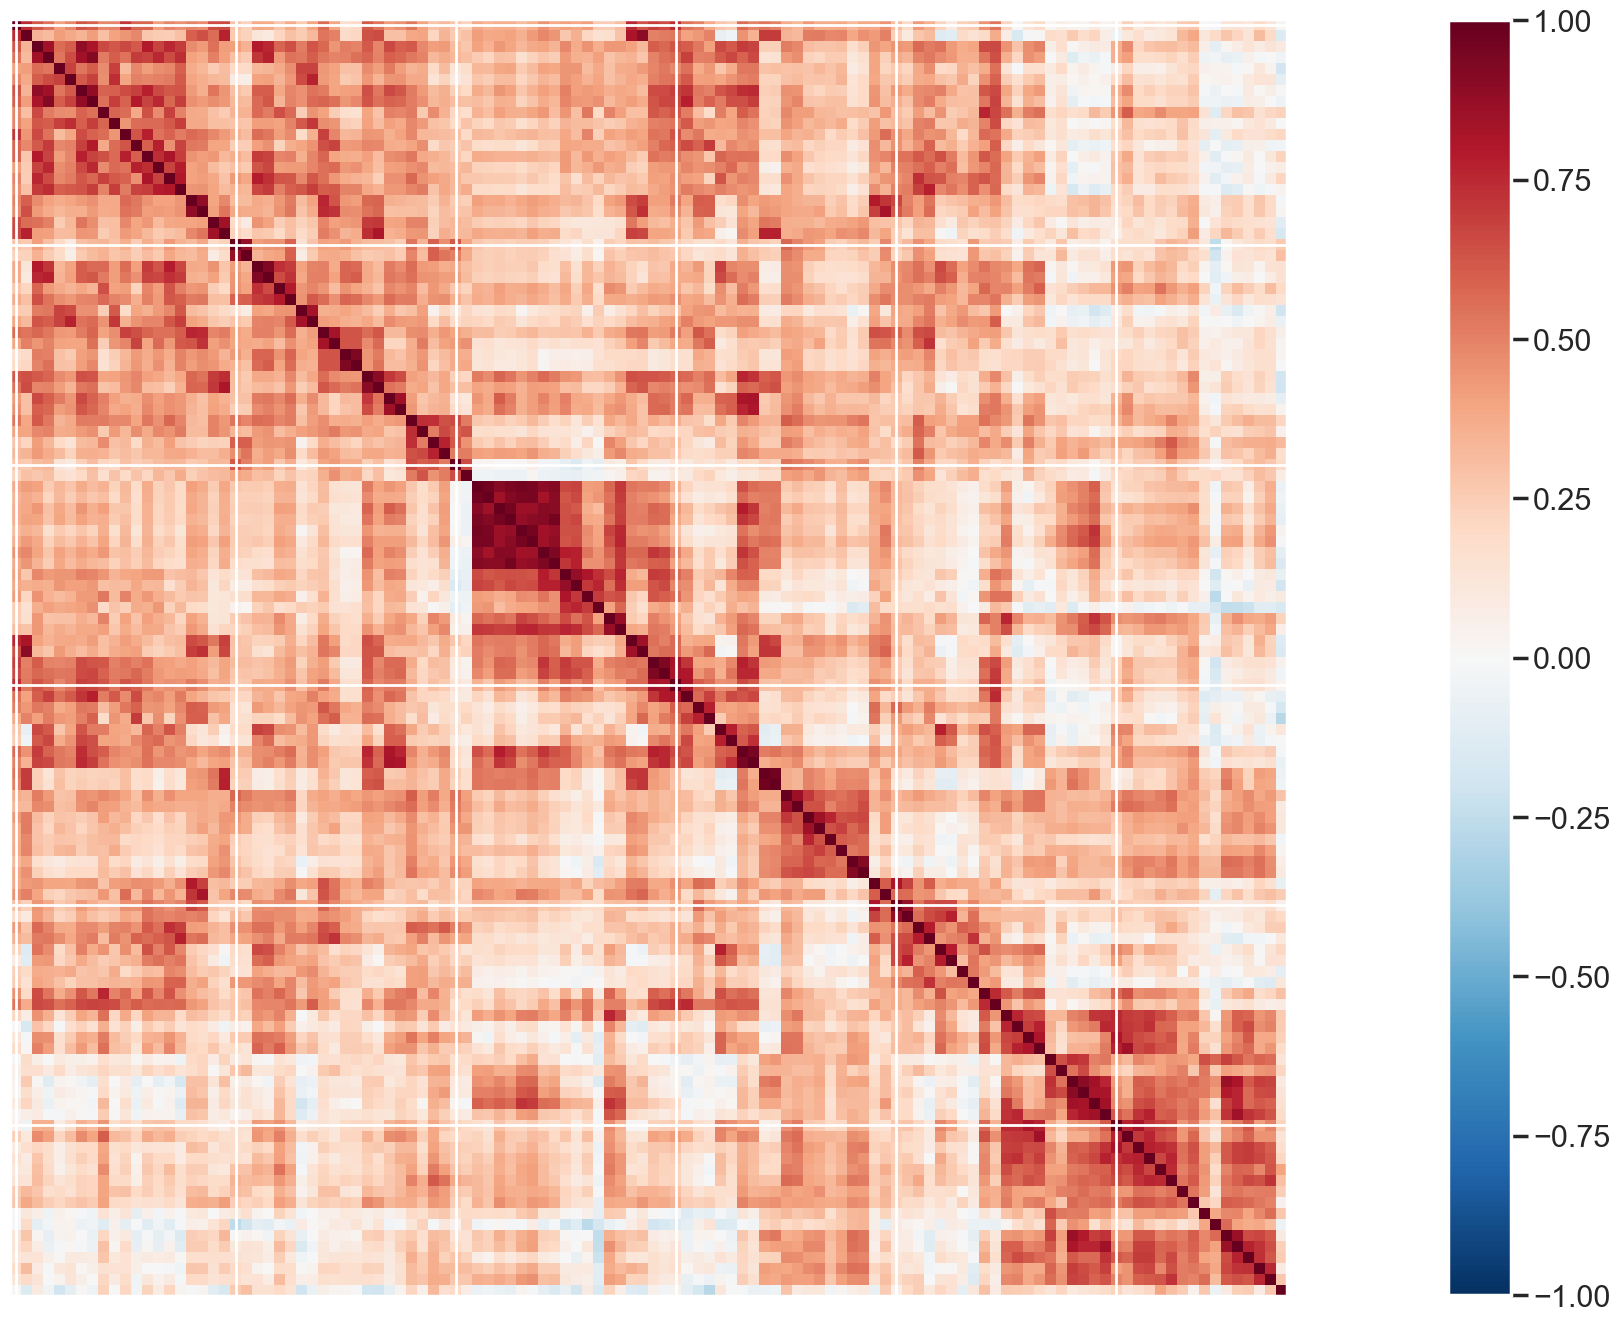

In [130]:
cmat = pd.read_csv("../resources/DataSujetos/N3_suj1.csv",header=None) 

fig, ax = plt.subplots(figsize=(16, 16))
plotting.plot_matrix(cmat, vmax=1, vmin=-1, figure=fig);


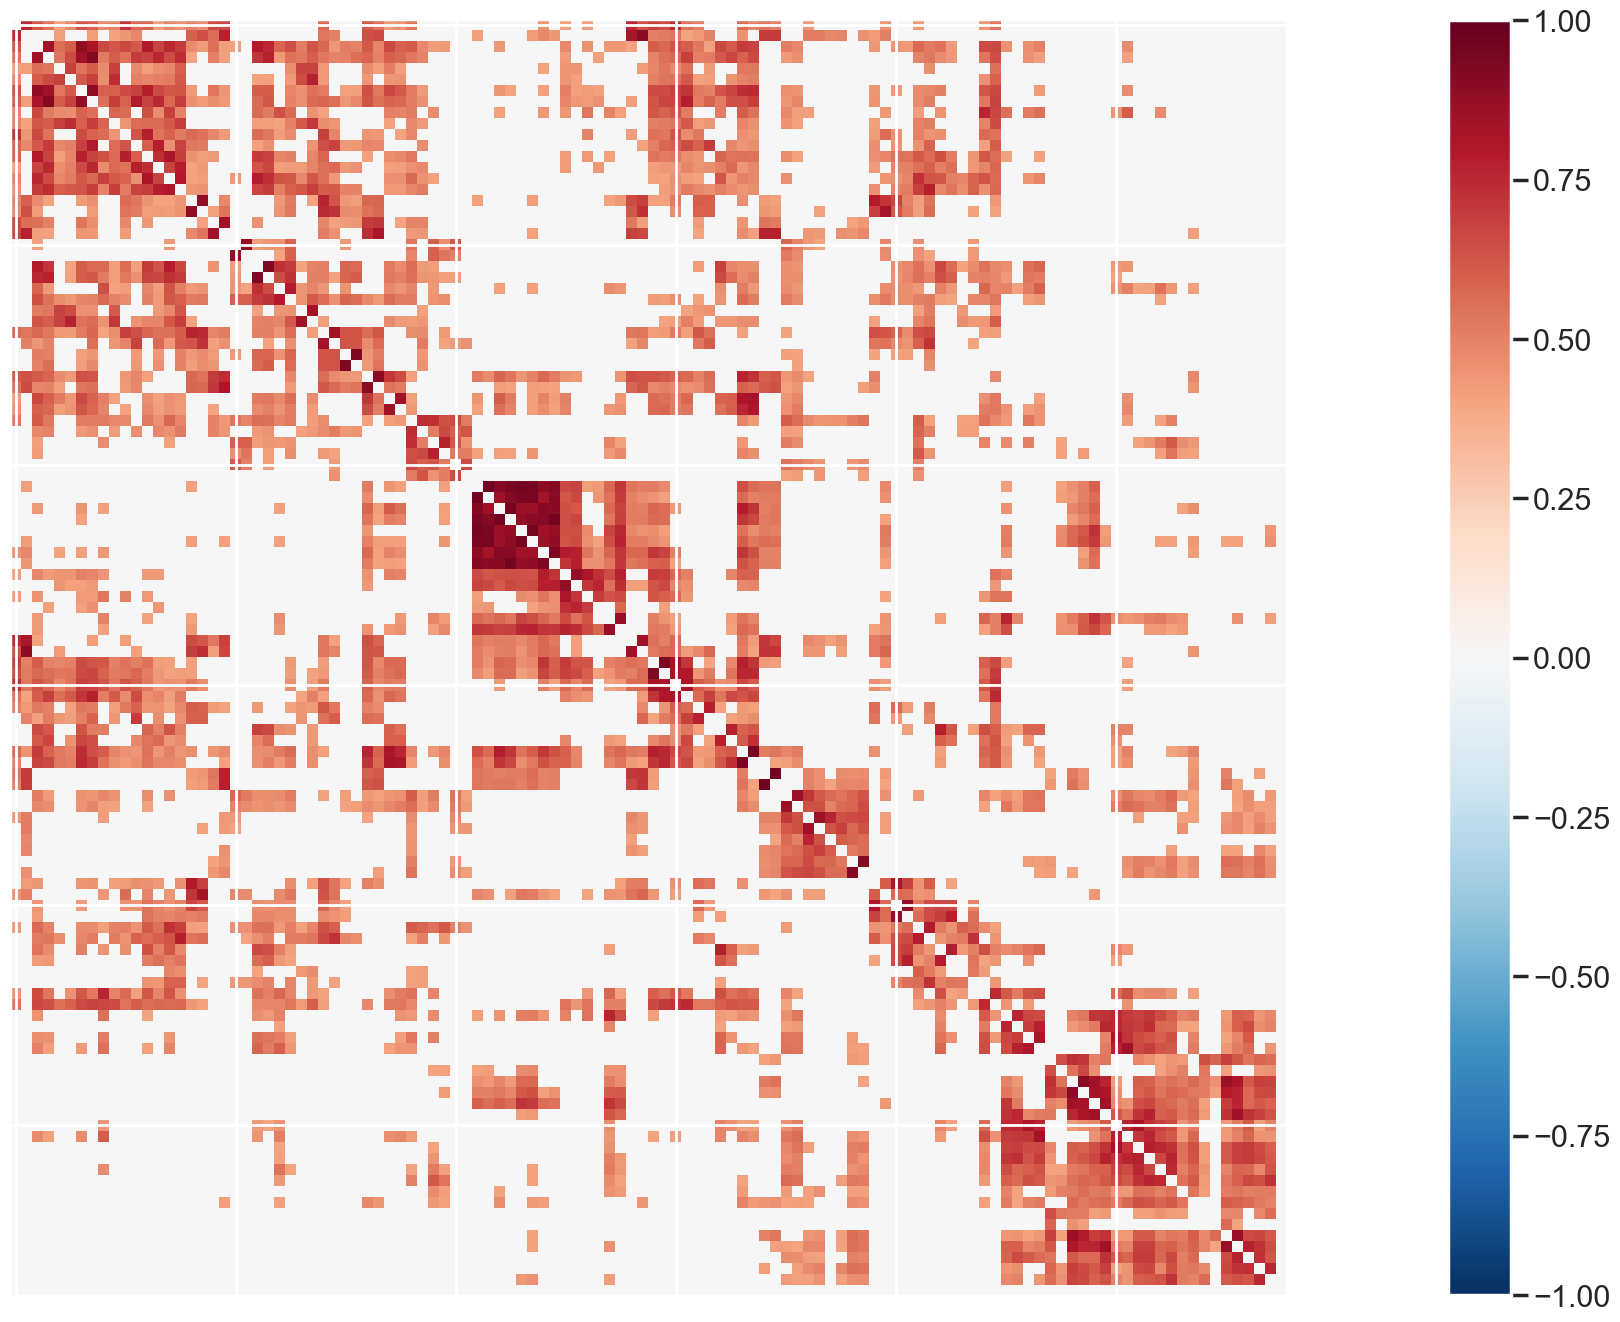

In [131]:
thresh_cmat = bct.threshold_absolute(cmat.values, thr=.4)

fig, ax = plt.subplots(figsize=(16, 16))
plotting.plot_matrix(thresh_cmat, vmax=1, vmin=-1, figure=fig);


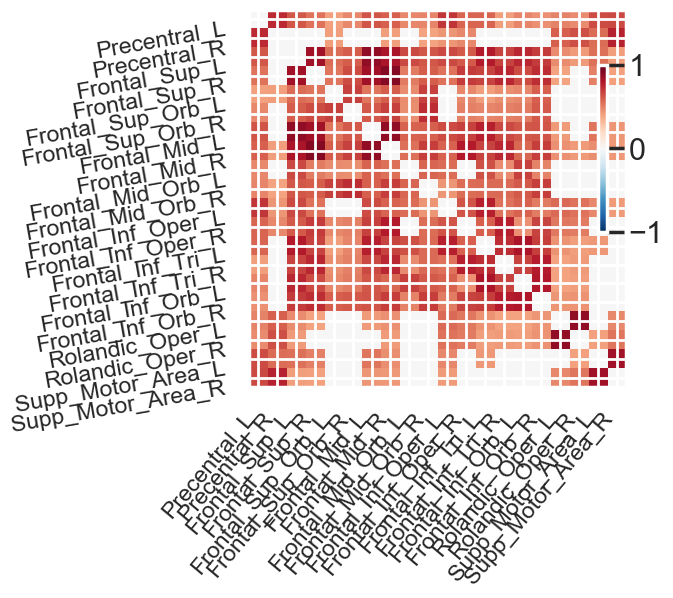

In [217]:
A = thresh_cmat[:20, :20]
#region_labels = [x[:3]+x[-6:] for x in labels[:20]]
region_labels = [x for x in labels[:20]]

plotting.plot_matrix(A, vmax=1, vmin=-1, labels=region_labels);


In [218]:
A.shape

(20, 20)

In [219]:
G = nx.from_numpy_matrix(A)
G = nx.relabel_nodes(G, lambda x: region_labels[x])

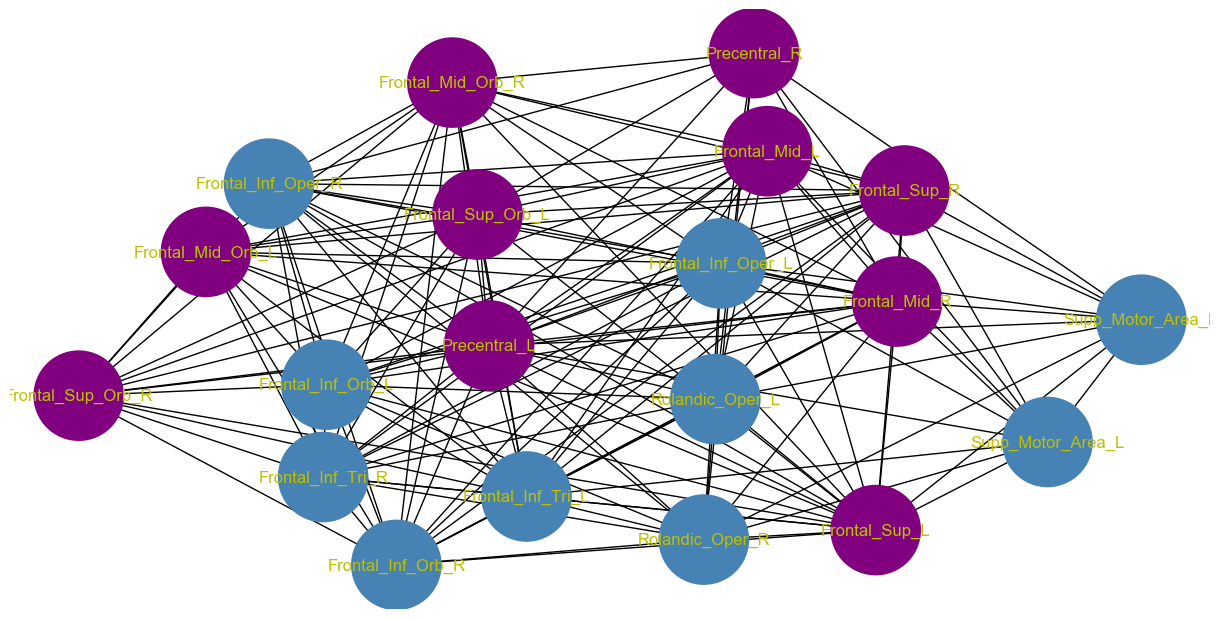

In [242]:
region_colors = ['purple'] * 10 + ['steelblue'] * 10

nx.draw_kamada_kawai(G, node_color=region_colors, node_size=4000, label_size=4,
                     with_labels=True, font_color='y')


In [243]:
edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
edges[:4]


(('Precentral_L', 'Precentral_R'),
 ('Precentral_L', 'Frontal_Sup_L'),
 ('Precentral_L', 'Frontal_Sup_R'),
 ('Precentral_L', 'Frontal_Sup_Orb_L'))

In [244]:
weights[:4]

(0.74255, 0.6191300000000001, 0.54596, 0.40973000000000004)

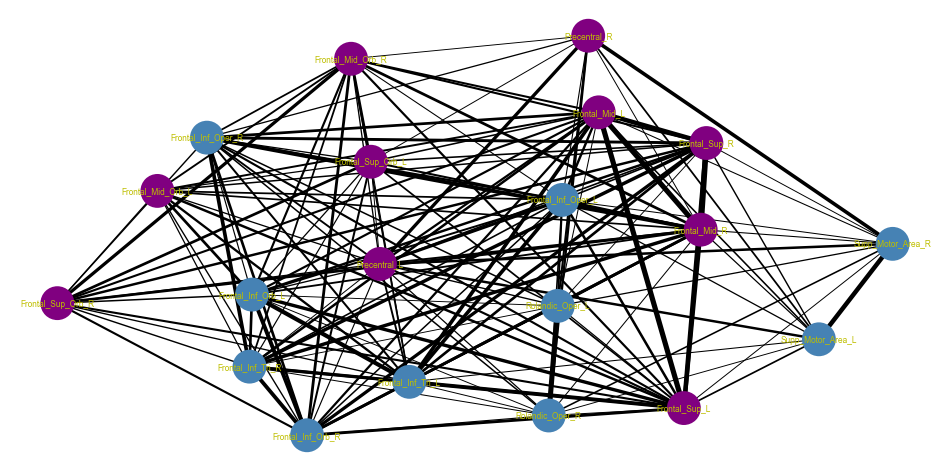

In [245]:
weight_widths = [(.5 + x) ** 4 for x in weights]

layout = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G, layout, node_color=region_colors, node_size=500, 
                       with_labels=True)
nx.draw_networkx_labels(G, layout, font_color='y', font_size=6)
nx.draw_networkx_edges(G, layout, edgelist=edges, width=weight_widths)
plt.axis('off');


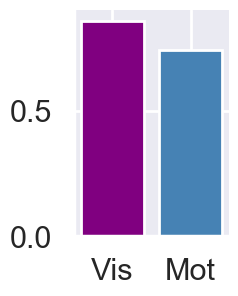

In [246]:
vis_density, n, k = bct.density_und(A[:9, :9])
mot_density, n, k = bct.density_und(A[9:, 9:])

fig, ax = plt.subplots(figsize=(2, 3))
ax.bar(['Vis', 'Mot'], [vis_density, mot_density],
       width=.8, color=['purple', 'steelblue'])
sns.despine()


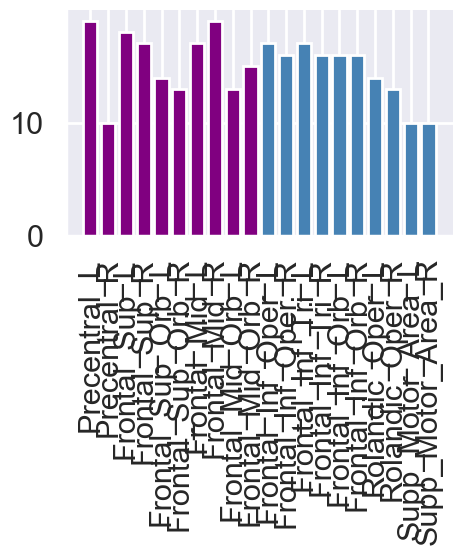

In [247]:
degrees = bct.degrees_und(A)

fig, ax = plt.subplots(figsize=(5, 3))
ax.bar(region_labels, degrees, width=.8, color=region_colors)
plt.xticks(rotation=90)
sns.despine()


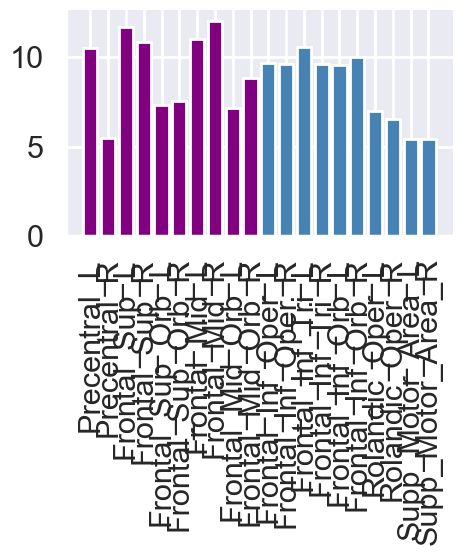

In [248]:
strengths = bct.strengths_und(A)

fig, ax = plt.subplots(figsize=(5, 3))
ax.bar(region_labels, strengths, width=.8, color=region_colors)
plt.xticks(rotation=90)
sns.despine()


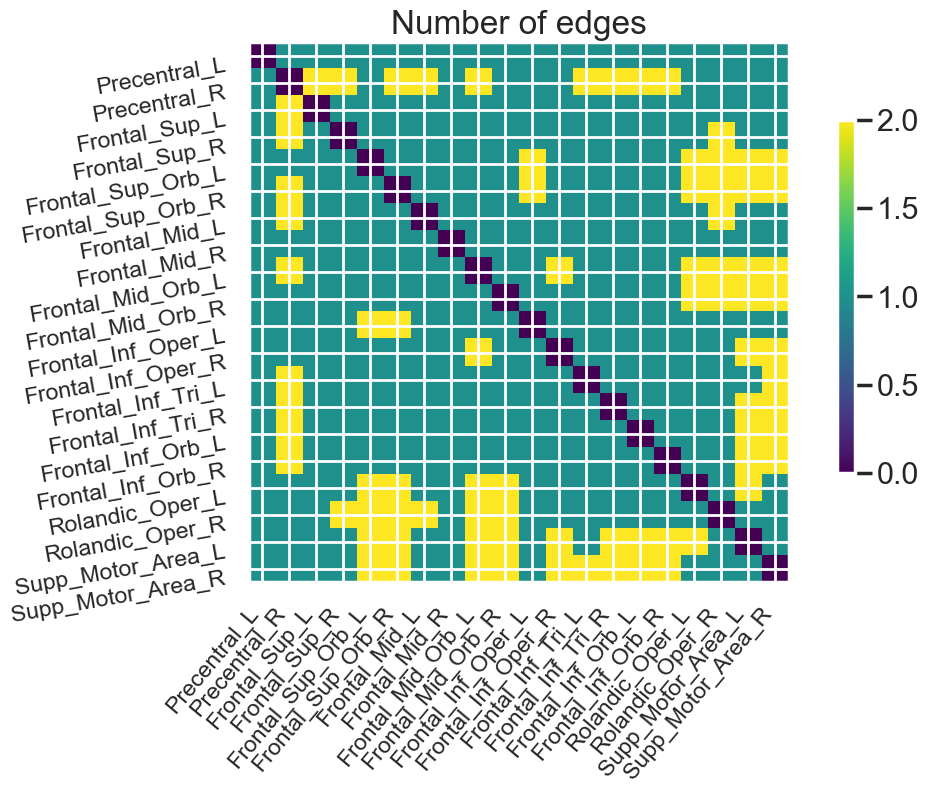

In [249]:
# need to convert A to inverse correlation or 'length' matrix
A_inv = bct.weight_conversion(A, 'lengths')

dist, num = bct.distance_wei(A_inv)

fig, ax = plt.subplots(figsize=(8, 8))
plotting.plot_matrix(num, vmin=0, labels=region_labels, 
                     figure=fig, cmap='viridis')
ax.set_title('Number of edges');


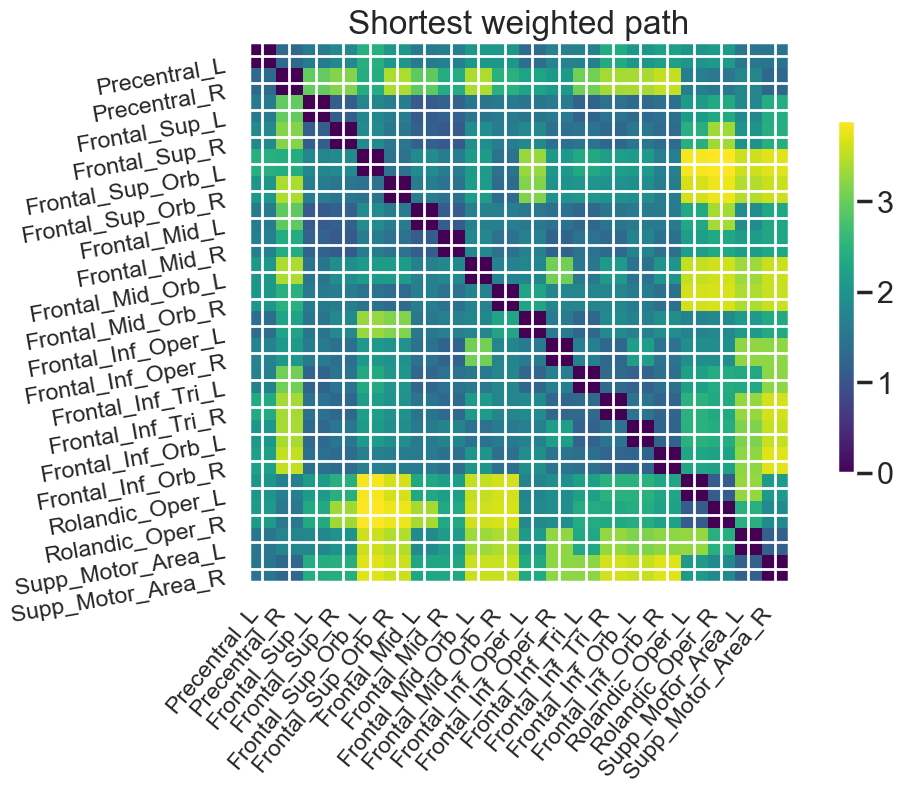

In [250]:
fig, ax = plt.subplots(figsize=(8, 8))
plotting.plot_matrix(dist, vmin=0, labels=region_labels, 
                     figure=fig, cmap='viridis')
ax.set_title('Shortest weighted path');


In [251]:
# exclude infinite values (white squares above)
characteristic_path = np.mean(dist[~np.isinf(dist)])
characteristic_path


2.0257893701038787

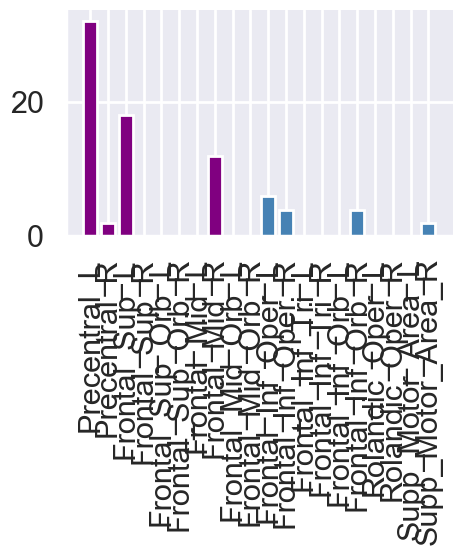

In [252]:
# input the inverse matrix
between_cent = bct.betweenness_wei(A_inv)

fig, ax = plt.subplots(figsize=(5, 3))
ax.bar(region_labels, between_cent, width=.8, color=region_colors)
plt.xticks(rotation=90)
sns.despine()


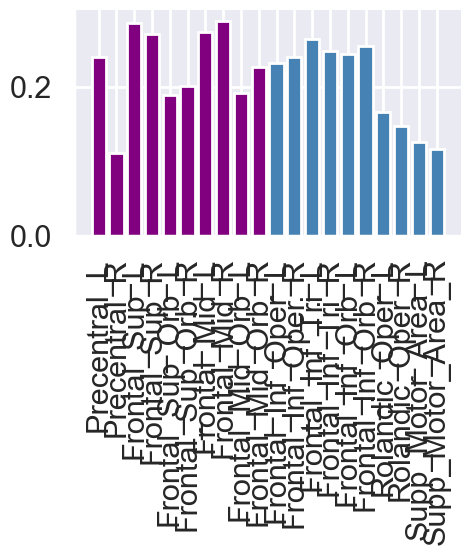

In [253]:
eigin_cent = bct.eigenvector_centrality_und(A)

fig, ax = plt.subplots(figsize=(5, 3))
ax.bar(region_labels, eigin_cent, width=.8, color=region_colors)
plt.xticks(rotation=90)
sns.despine()


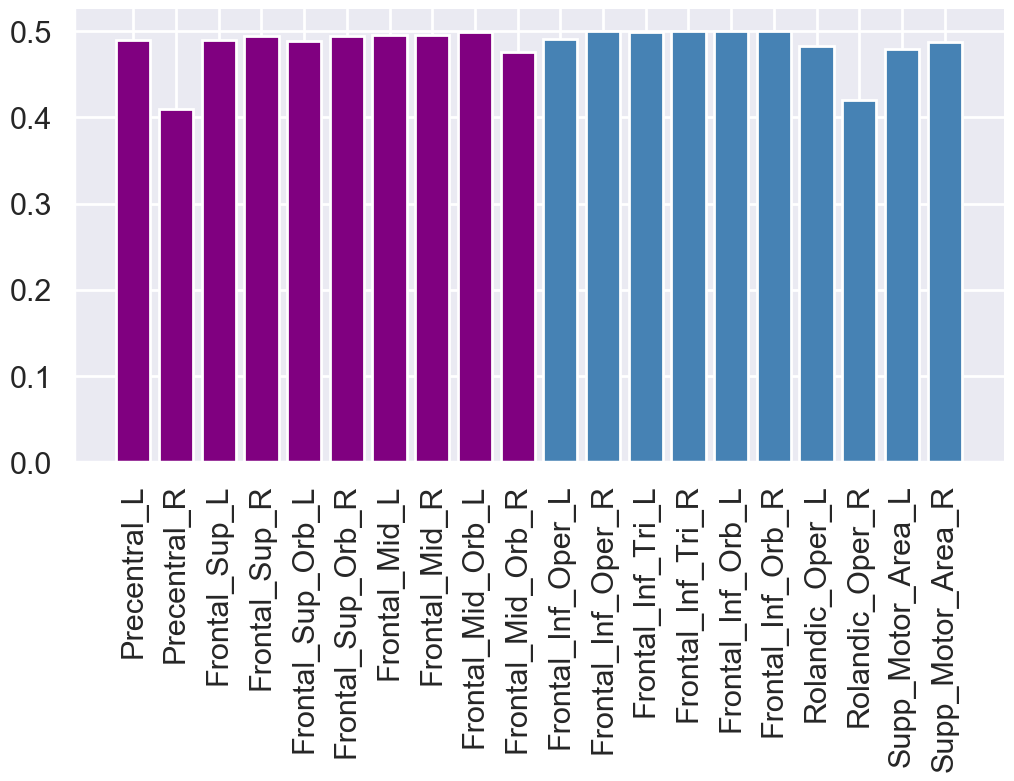

In [254]:
# label based on Vis or Mot
network_index = [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,]
participation = bct.participation_coef(A, network_index)

plt.bar(region_labels, participation, width=.8, color=region_colors)
plt.xticks(rotation=90)
sns.despine()


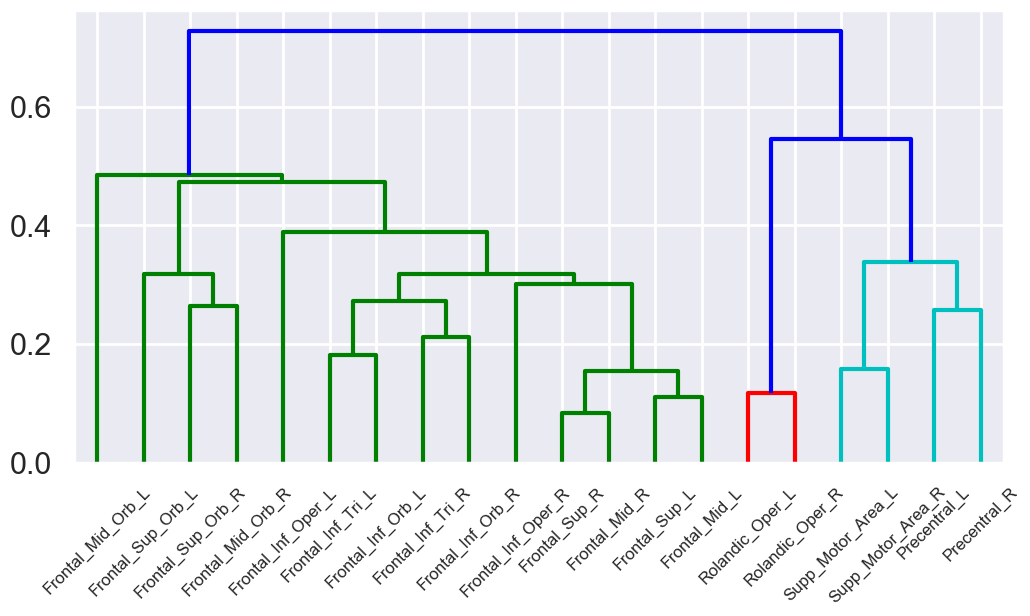

In [255]:
# get upper triangle
distances = spatial.distance.squareform(1 - A, checks=False)

# apply hierarchical clustering 
linkages = cluster.hierarchy.linkage(distances, method='average')

# plot dendogram
dendo = cluster.hierarchy.dendrogram(linkages, labels=region_labels)
plt.xticks(rotation=45);


In [256]:
modul, q = bct.modularity_und(A)
q


0.10898581474572117

In [257]:
modul_louvain, q = bct.community_louvain(A)
q


0.10898581474572125

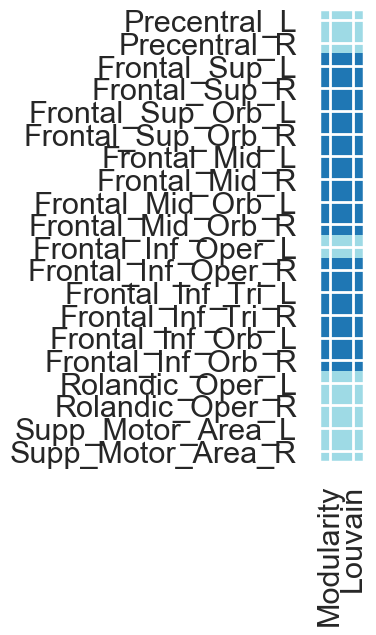

In [258]:
fig, ax = plt.subplots()
ax.imshow(np.array([modul, modul_louvain]).T, cmap='tab20')
ax.set(yticklabels=region_labels, yticks=range(len(region_labels)), 
       xticklabels=['Modularity', 'Louvain'], xticks=[0, 1]);
plt.xticks(rotation=90);


In [259]:
label_data = pd.DataFrame({'number': np.arange(len(labels)) + 1, 'region': labels})
label_data


number             region
0         1       Precentral_L
1         2       Precentral_R
2         3      Frontal_Sup_L
3         4      Frontal_Sup_R
4         5  Frontal_Sup_Orb_L
..      ...                ...
111     112           Vermis_6
112     113           Vermis_7
113     114           Vermis_8
114     115           Vermis_9
115     116          Vermis_10

[116 rows x 2 columns]

In [260]:
label_data.query("number == 30")


number    region
29      30  Insula_R

In [261]:
def set_color(x):
    y = {'Frontal': '#0173b2', 'Temporal': '#de8f05', 'Parietal': '#029e73', 'Central': '#d55e00', 'Limbic': '#cc78bc', 'Occipital': '#ca9161', 'Insula': '#fbafe4', 'Subcortical': '#949494', 'Cerebelum': '#ece133'}
    return y[x]
node_colors = [set_color(x) for x in dfLabels['region'].values]
node_network = dfLabels['region'].values


In [262]:
G = nx.from_numpy_matrix(thresh_cmat)
G = nx.relabel_nodes(G, lambda x: label_data['number'].tolist()[x])


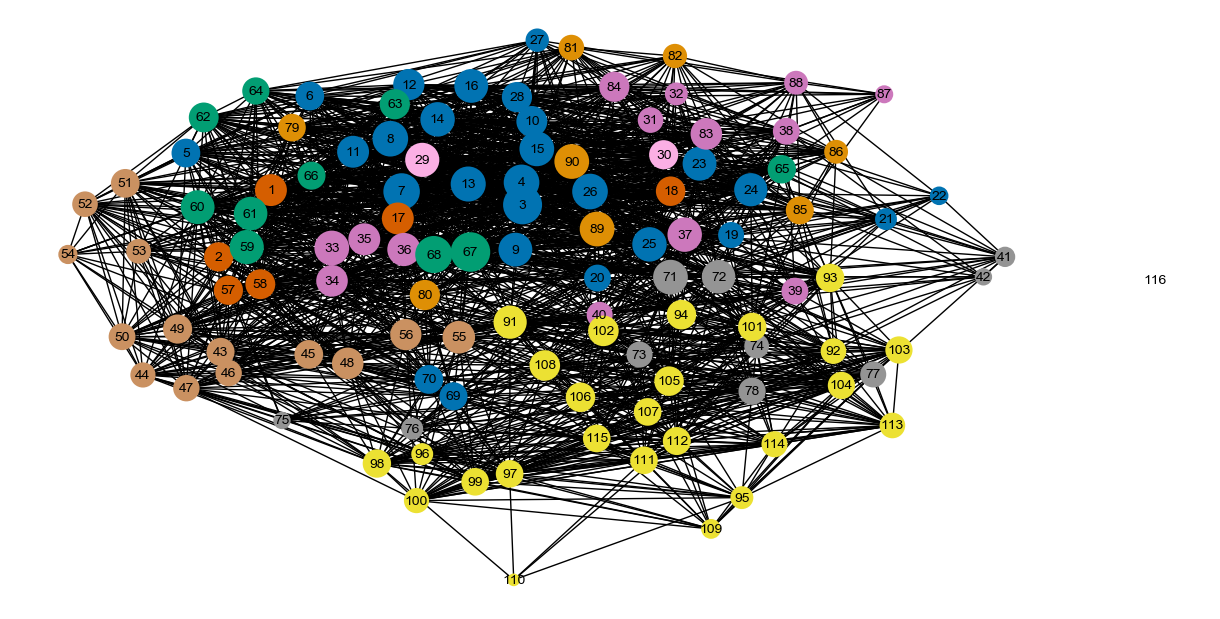

In [263]:
nx.draw_kamada_kawai(G, node_color=node_colors, node_size = [j * 10 for i, j in nx.degree(G)], font_size=10, with_labels=True)


Y este prox grafico lo saqué de un koreanito que hizo un gráfico re copado
https://github.com/ksundae1/MgtDatabase2018/blob/6eca4e86c78ebf2a10fa83edba0c1be079c9bd3d/MGT2018/%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D4/.ipynb_checkpoints/Network%20Analysis_student-checkpoint.ipynb

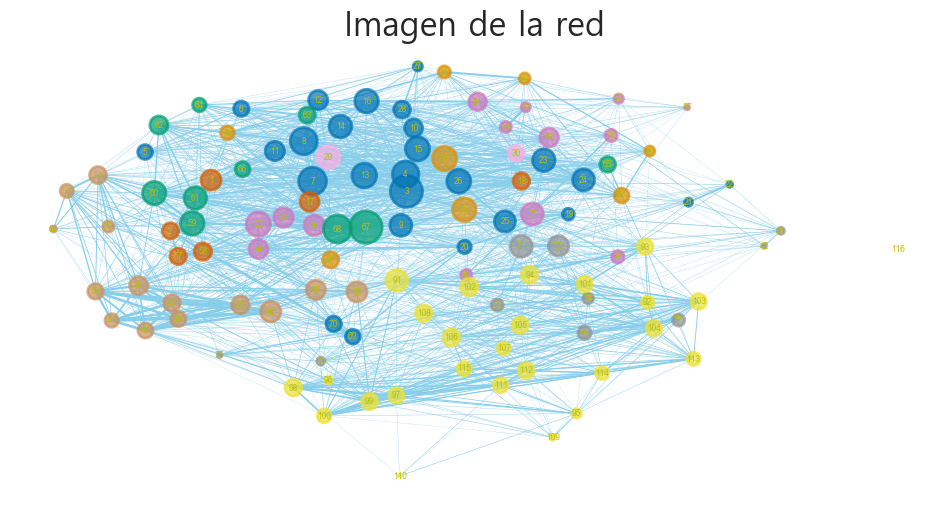

In [298]:
edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())

weight_widths = [(.2 + x) ** 4 for x in weights]
node_size = [(.1+.6*j)**2. for i, j in nx.degree(G,weight='weight')]

layout = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G, layout, 
                     node_size = node_size,
                     node_color=node_colors,
                     edge_color = "skyblue", # 엣지 색상
                     # edge_color=colors,
                     alpha = 0.7, # 노드와 엣지의 투명도
                     with_labels = True, # 노드 이름 표시 여부
                     font_size=10, # 폰트 사이즈
                     font_family='Malgun Gothic', # 한글설정
                     arrowsize = 10) # 화살표 크기
nx.draw_networkx_labels(G, layout, font_color='y', font_size=6)
nx.draw_networkx_edges(G, layout, edgelist=edges, width=weight_widths, edge_color = "skyblue")

plt.rc('font', family='Malgun Gothic') # 폰트 문제
plt.title('Imagen de la red') # 그래프 제목
plt.axis('off');
#plt.savefig('second_network.png') # 파일 저장

In [299]:
pd.DataFrame(list(nx.degree(G))).sort_values(by=1, ascending = False).head(10)

0   1
66  67  70
2    3  68
67  68  61
6    7  59
3    4  56
25  26  56
7    8  56
12  13  54
14  15  53
89  90  53

In [305]:
nx.degree_centrality(G)

{1: 0.3826086956521739,
 2: 0.3130434782608696,
 3: 0.591304347826087,
 4: 0.48695652173913045,
 5: 0.30434782608695654,
 6: 0.30434782608695654,
 7: 0.5130434782608696,
 8: 0.48695652173913045,
 9: 0.43478260869565216,
 10: 0.3565217391304348,
 11: 0.3826086956521739,
 12: 0.3652173913043478,
 13: 0.46956521739130436,
 14: 0.45217391304347826,
 15: 0.4608695652173913,
 16: 0.43478260869565216,
 17: 0.3826086956521739,
 18: 0.32173913043478264,
 19: 0.24347826086956523,
 20: 0.2608695652173913,
 21: 0.16521739130434782,
 22: 0.11304347826086956,
 23: 0.43478260869565216,
 24: 0.4173913043478261,
 25: 0.45217391304347826,
 26: 0.48695652173913045,
 27: 0.19130434782608696,
 28: 0.3391304347826087,
 29: 0.4434782608695652,
 30: 0.3130434782608696,
 31: 0.23478260869565218,
 32: 0.1826086956521739,
 33: 0.4608695652173913,
 34: 0.3739130434782609,
 35: 0.3826086956521739,
 36: 0.4173913043478261,
 37: 0.45217391304347826,
 38: 0.2608695652173913,
 39: 0.2608695652173913,
 40: 0.2434782608

In [304]:
nx.closeness_centrality(G)


{1: 0.6011100832562443,
 2: 0.5736482012800707,
 3: 0.6933048813016804,
 4: 0.6348803126526624,
 5: 0.5381366459627329,
 6: 0.5305572565829761,
 7: 0.6532294546368435,
 8: 0.6243574345423973,
 9: 0.6313334952635414,
 10: 0.5765749778172139,
 11: 0.5736482012800707,
 12: 0.5622323166774822,
 13: 0.6384672070744288,
 14: 0.5947826086956521,
 15: 0.6243574345423973,
 16: 0.5885869565217392,
 17: 0.6043245756800745,
 18: 0.5795317725752509,
 19: 0.5485859012241452,
 20: 0.5650434782608695,
 21: 0.5231884057971015,
 22: 0.5000384763370528,
 23: 0.6243574345423973,
 24: 0.6175338560228083,
 25: 0.6384672070744288,
 26: 0.6532294546368435,
 27: 0.4850158611681284,
 28: 0.5566930820304133,
 29: 0.6141776937618147,
 30: 0.5512619300106045,
 31: 0.5381366459627329,
 32: 0.5207773993187738,
 33: 0.6384672070744288,
 34: 0.6011100832562443,
 35: 0.6043245756800745,
 36: 0.6175338560228083,
 37: 0.6384672070744288,
 38: 0.5433110367892977,
 39: 0.5678828927244921,
 40: 0.5650434782608695,
 41: 0.49

In [85]:
nx.betweenness_centrality(G)


{1: 0.00523002156484447,
 2: 0.008458865496438801,
 3: 0.020135986223848545,
 4: 0.009917197126928593,
 5: 0.00176538105115025,
 6: 0.001070453983947898,
 7: 0.013754682702906348,
 8: 0.009494864296292234,
 9: 0.00875923555733399,
 10: 0.0024638422105047173,
 11: 0.003354051995678061,
 12: 0.002655815673254265,
 13: 0.007963654365605555,
 14: 0.007100138660927791,
 15: 0.00866854569507622,
 16: 0.005554898433288248,
 17: 0.007353928283631012,
 18: 0.005987299817895239,
 19: 0.003432587017308051,
 20: 0.00445598421190599,
 21: 0.0015362276828902054,
 22: 0.0004542200319058987,
 23: 0.009387572439622799,
 24: 0.008757162156641376,
 25: 0.020168138522446748,
 26: 0.013371745721308415,
 27: 0.0006385594719276672,
 28: 0.0025819550869960978,
 29: 0.005924360585699172,
 30: 0.006390573651788673,
 31: 0.0014118742490343663,
 32: 0.00037790005700932003,
 33: 0.012961189568028098,
 34: 0.007479264377705615,
 35: 0.004965412112670323,
 36: 0.006901102607390396,
 37: 0.02541085388606494,
 38: 0.0

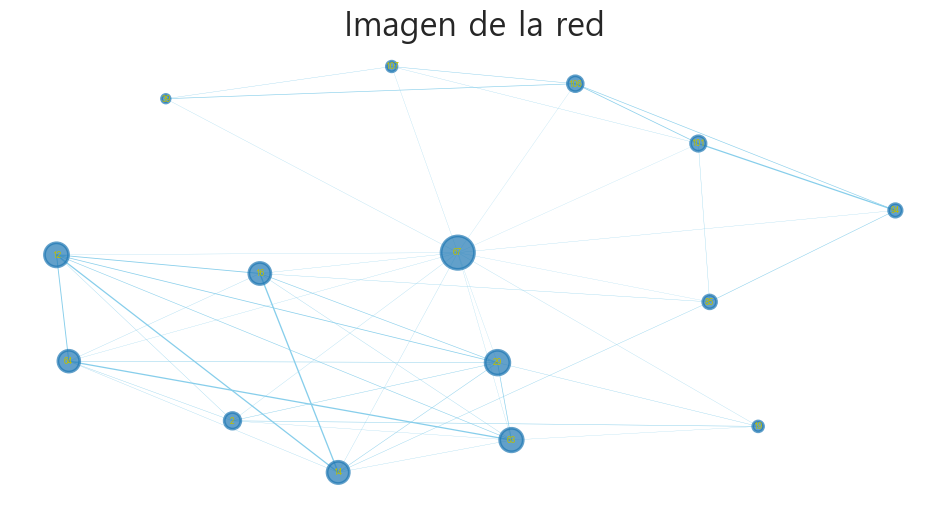

In [310]:
# SUBNETWORK ALREDEDOR DEL NODO 67
eG = nx.ego_graph(G, 67, radius=.45, center=True, undirected=True, distance='weight')


edges, weights = zip(*nx.get_edge_attributes(eG,'weight').items())

weight_widths = [(.2 + x) ** 4 for x in weights]
node_size = [(.1+4*j)**2. for i, j in nx.degree(eG,weight='weight')]

layout = nx.kamada_kawai_layout(eG)
nx.draw_networkx_nodes(eG, layout, 
                     node_size = node_size,
                     edge_color = "skyblue", # 엣지 색상
                     # edge_color=colors,
                     alpha = 0.7, # 노드와 엣지의 투명도
                     with_labels = True, # 노드 이름 표시 여부
                     font_size=10, # 폰트 사이즈
                     font_family='Malgun Gothic', # 한글설정
                     arrowsize = 10) # 화살표 크기
nx.draw_networkx_labels(eG, layout, font_color='y', font_size=6)
nx.draw_networkx_edges(eG, layout, edgelist=edges, width=weight_widths, edge_color = "skyblue")

plt.rc('font', family='Malgun Gothic') # 폰트 문제
plt.title('Imagen de la red') # 그래프 제목
plt.axis('off');
#plt.savefig('second_network.png') # 파일 저장

In [311]:
print("Number of Nodes : ", nx.number_of_nodes(G))
print("Number of Edges : ", nx.number_of_edges(G))
degreelist = list(pd.DataFrame(list(nx.degree(G))).iloc[:,1])
print("Avg. Node Degree : ", float(sum(degreelist))/nx.number_of_nodes(G))
#print("Avg. Path Length : ", nx.average_shortest_path_length(G))


Number of Nodes :  116
Number of Edges :  2080
Avg. Node Degree :  35.86206896551724


In [312]:
# change A to entire brain
A = thresh_cmat


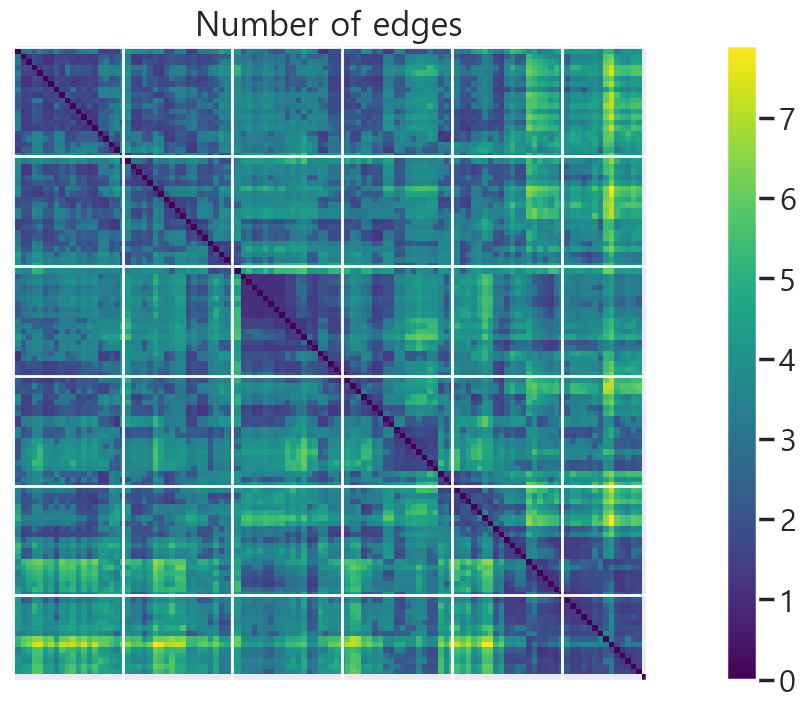

In [313]:
A_inv = bct.weight_conversion(A, 'lengths')

dist, num = bct.distance_wei(A_inv)

fig, ax = plt.subplots(figsize=(8, 8))
plotting.plot_matrix(dist, vmin=0,
                     figure=fig, cmap='viridis')
ax.set_title('Number of edges');


In [314]:
def stat_map(x, atlas):

    img_data = atlas.get_fdata()
    indices = np.unique(img_data)[1:]

    arr = img_data.copy()
    for val, i in zip(x, indices):
        arr = np.where(arr == i, val, arr)
        
    return nib.Nifti1Image(arr, atlas.affine)


In [315]:
degrees = bct.degrees_und(A)
strengths = bct.strengths_und(A)
eigin_cent = bct.eigenvector_centrality_und(A)
between_cent = bct.betweenness_wei(A_inv)

participation = bct.participation_coef(A, node_network)


C:\Users\Faolin\anaconda3\lib\site-packages\bct\algorithms\centrality.py:760: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


C:\Users\Faolin\anaconda3\lib\site-packages\nilearn\plotting\js_plotting_utils.py:85: UserWarning: choosing both vmin and a threshold is not allowed; setting vmin to 0
  warnings.warn('choosing both vmin and a threshold is not allowed; '



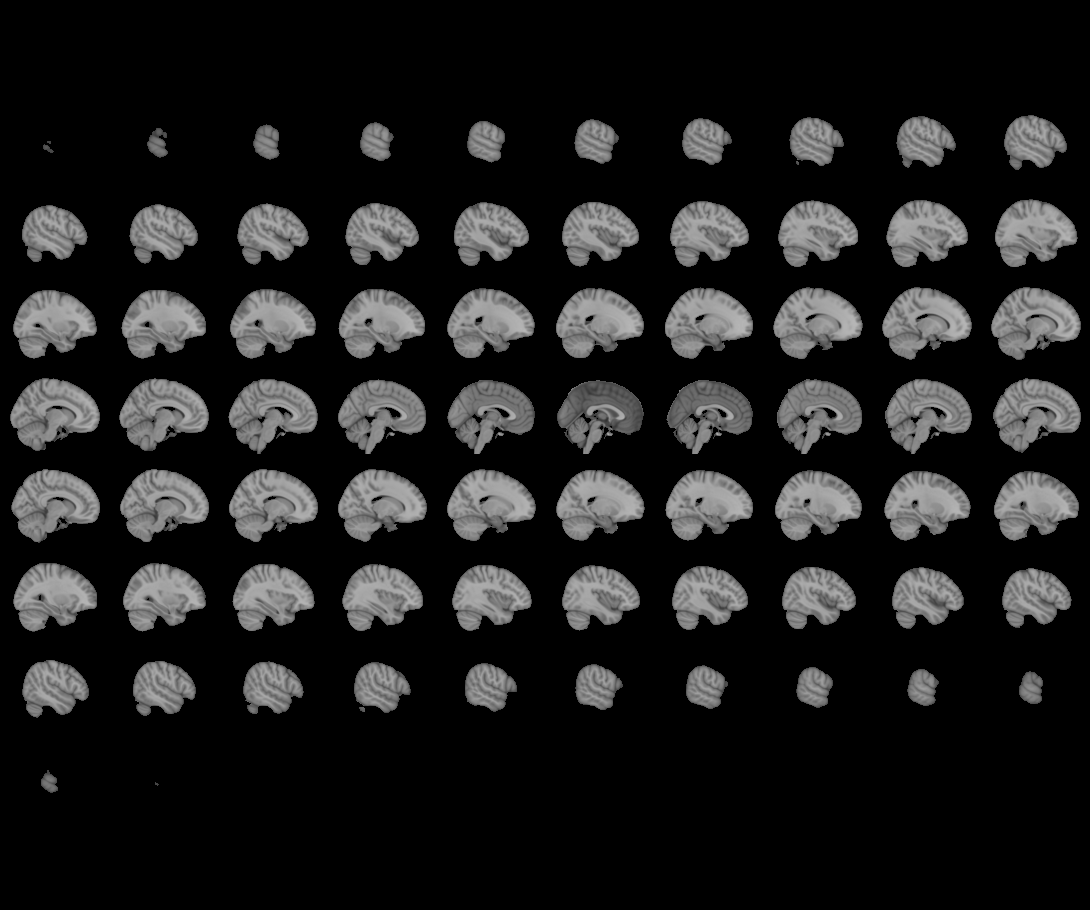
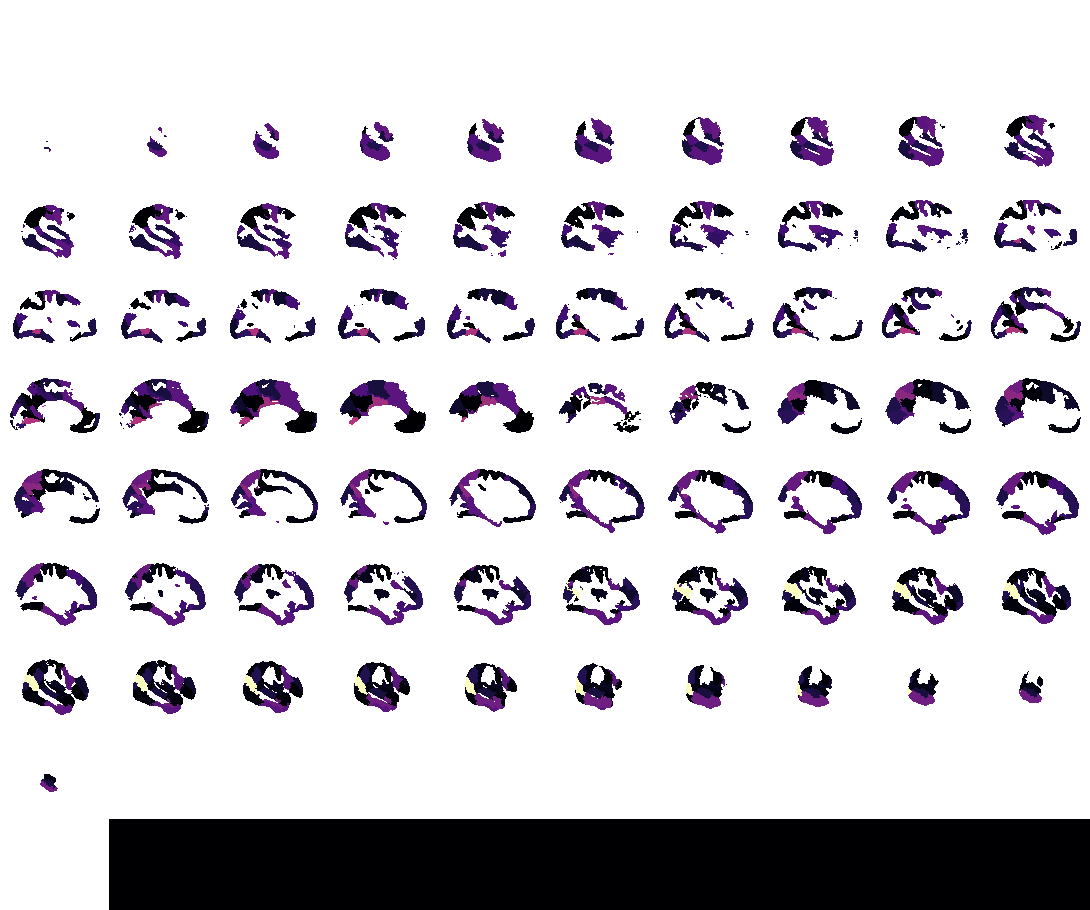

In [316]:
atlas_img = nib.load(atlas['maps'])

res = stat_map(between_cent, atlas_img)
plotting.view_img(res, vmin=0, cmap='magma', symmetric_cmap=False)


C:\Users\Faolin\anaconda3\lib\site-packages\bct\algorithms\centrality.py:760: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)
C:\Users\Faolin\anaconda3\lib\site-packages\nilearn\plotting\js_plotting_utils.py:85: UserWarning: choosing both vmin and a threshold is not allowed; setting vmin to 0
  warnings.warn('choosing both vmin and a threshold is not allowed; '



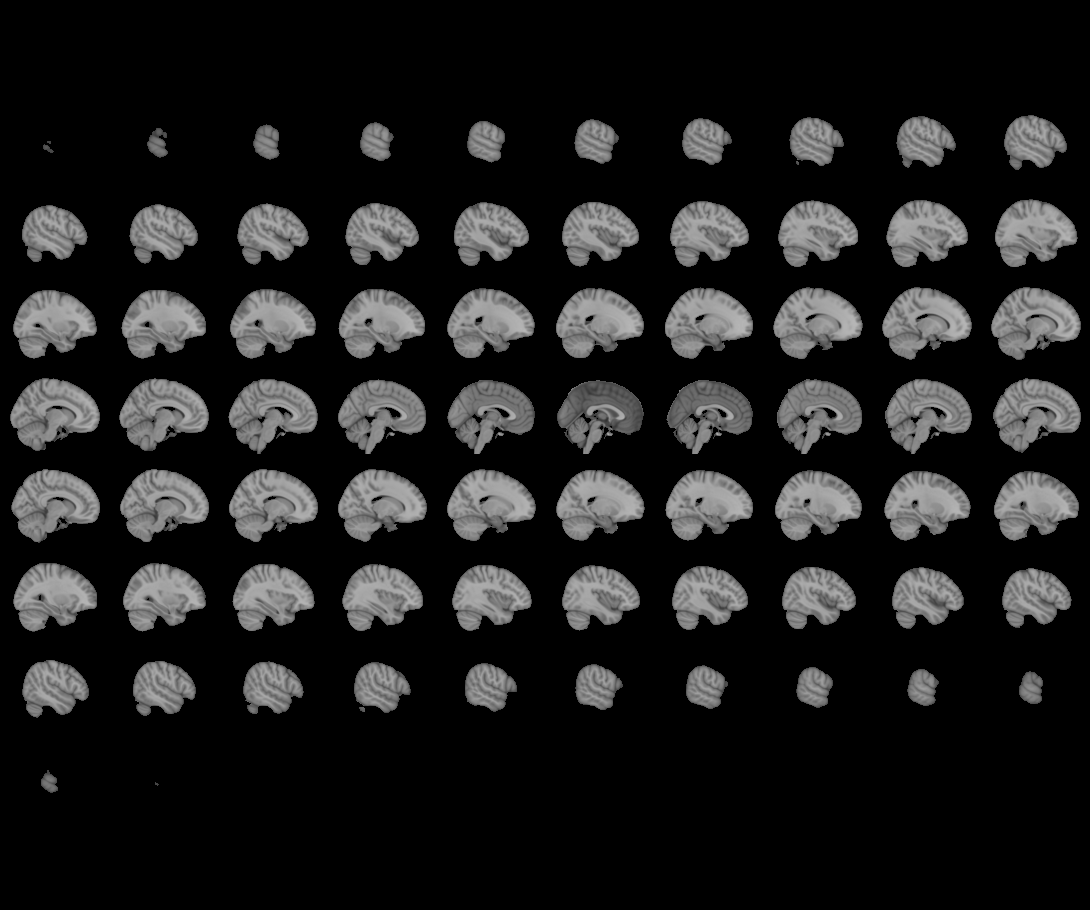
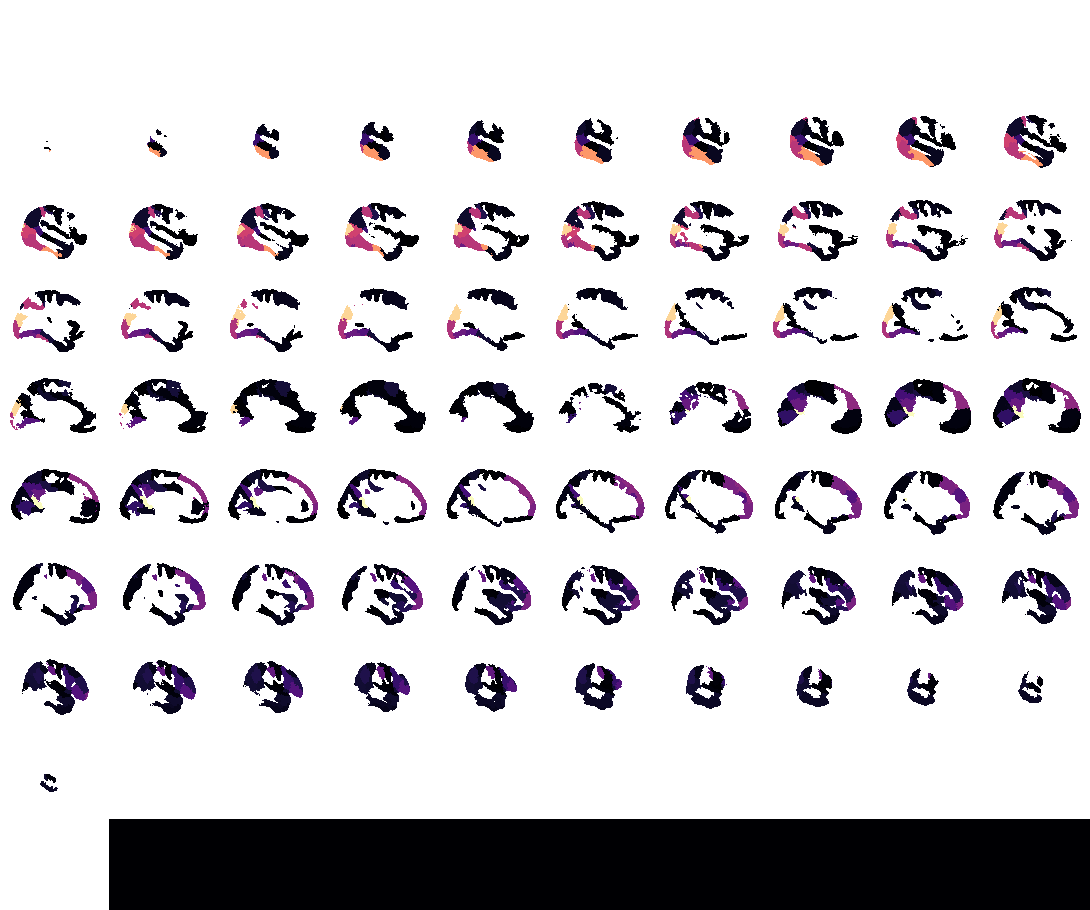

C:\Users\Faolin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Faolin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


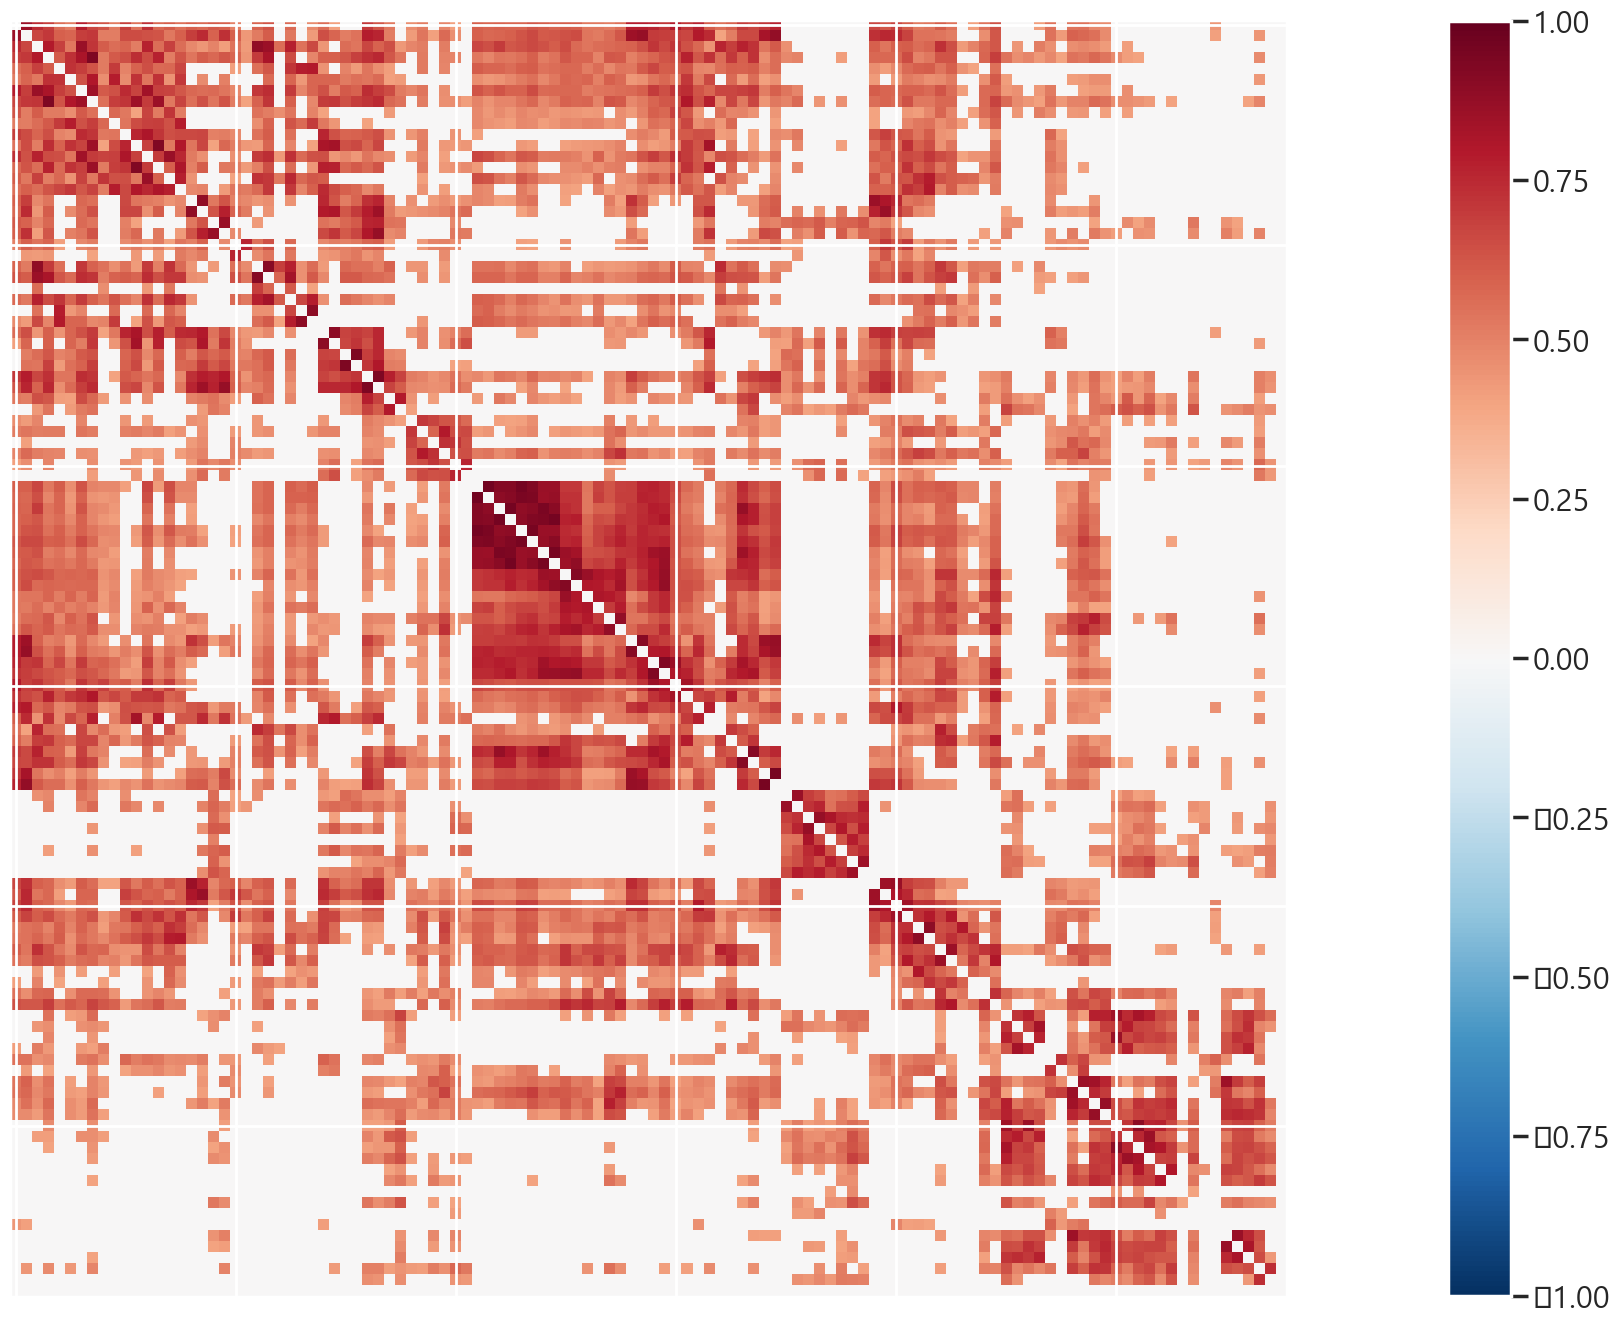

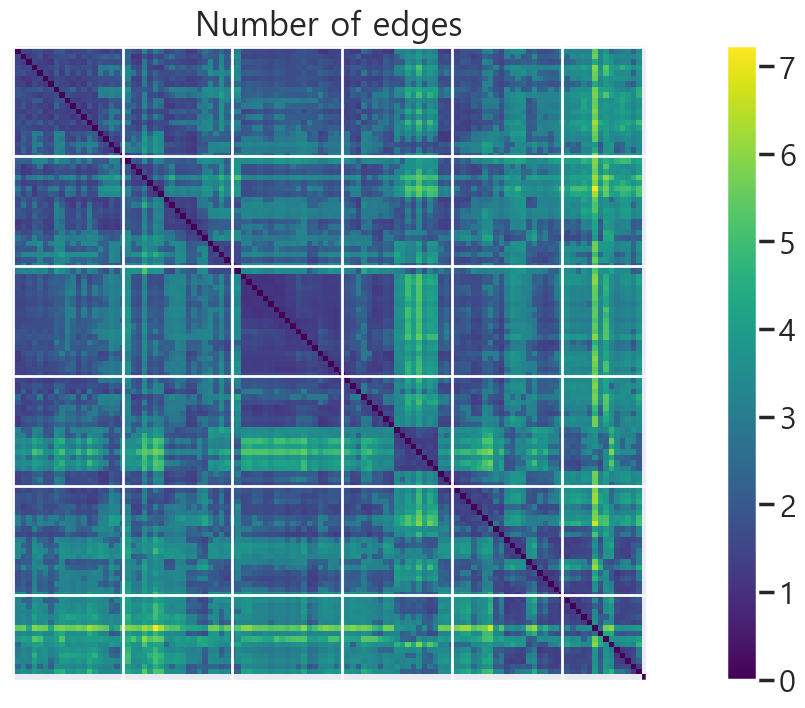

In [317]:
cmat = pd.read_csv("../resources/DataSujetos/N1_suj1.csv",header=None) 

thresh_cmat = bct.threshold_absolute(cmat.values, thr=.4)

fig, ax = plt.subplots(figsize=(16, 16))
plotting.plot_matrix(thresh_cmat, vmax=1, vmin=-1, figure=fig);

A = thresh_cmat

A_inv = bct.weight_conversion(A, 'lengths')

dist, num = bct.distance_wei(A_inv)

fig, ax = plt.subplots(figsize=(8, 8))
plotting.plot_matrix(dist, vmin=0,
                     figure=fig, cmap='viridis')
ax.set_title('Number of edges');


degrees = bct.degrees_und(A)
strengths = bct.strengths_und(A)
eigin_cent = bct.eigenvector_centrality_und(A)
between_cent = bct.betweenness_wei(A_inv)

participation = bct.participation_coef(A, node_network)

atlas_img = nib.load(atlas['maps'])

res = stat_map(between_cent, atlas_img)
plotting.view_img(res, vmin=0, cmap='magma', symmetric_cmap=False)


C:\Users\Faolin\anaconda3\lib\site-packages\bct\algorithms\centrality.py:760: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)
C:\Users\Faolin\anaconda3\lib\site-packages\nilearn\plotting\js_plotting_utils.py:85: UserWarning: choosing both vmin and a threshold is not allowed; setting vmin to 0
  warnings.warn('choosing both vmin and a threshold is not allowed; '



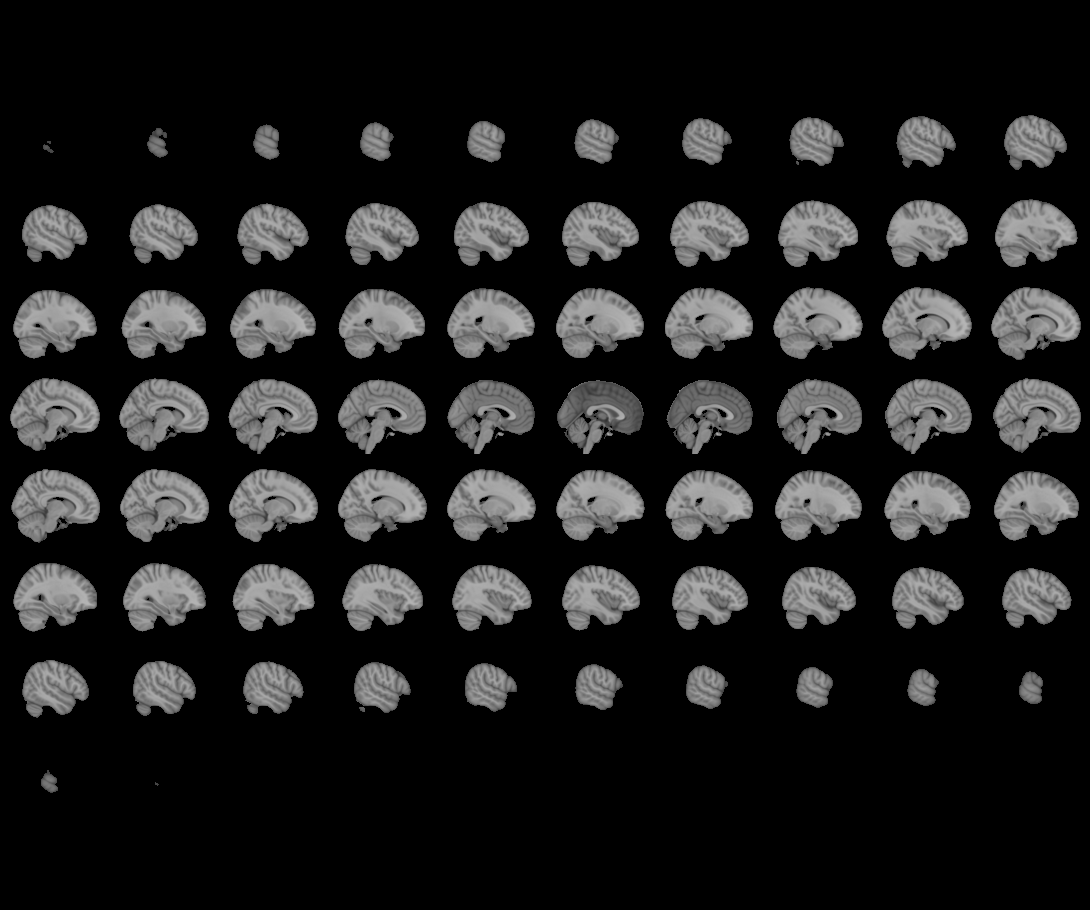
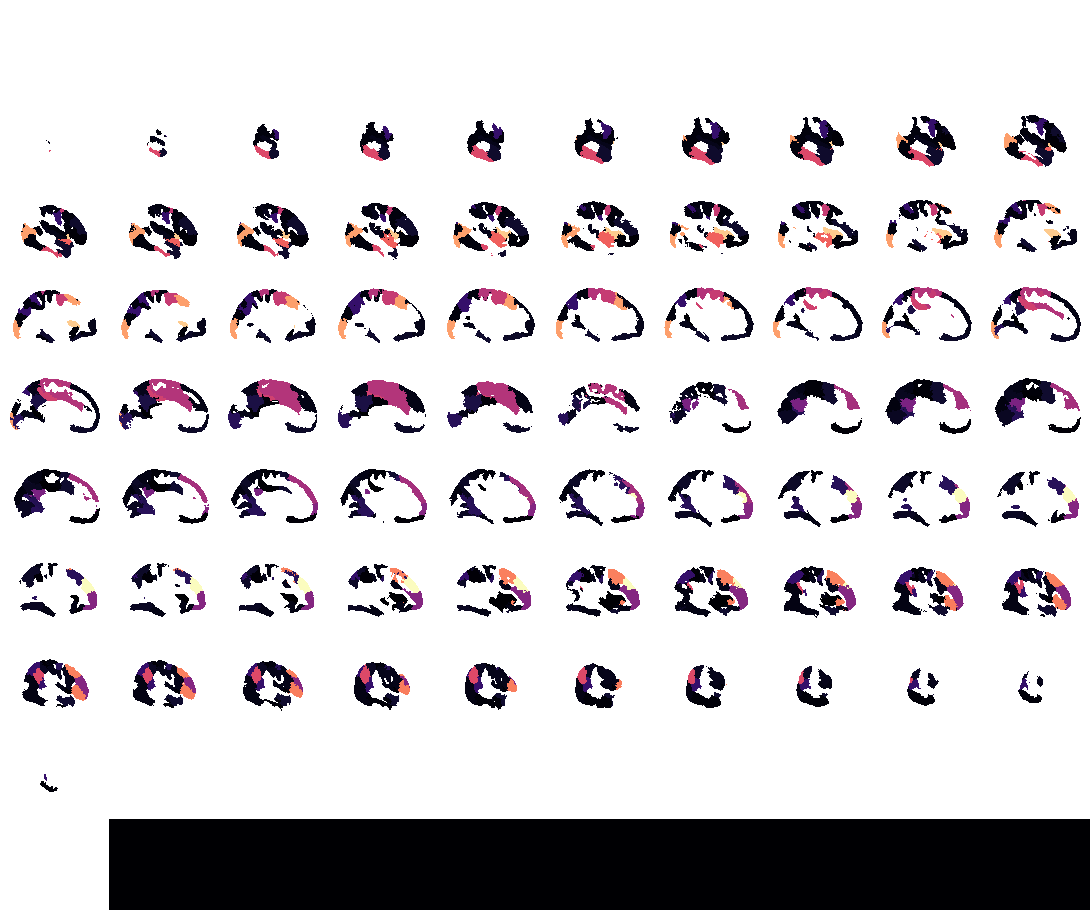

C:\Users\Faolin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Faolin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


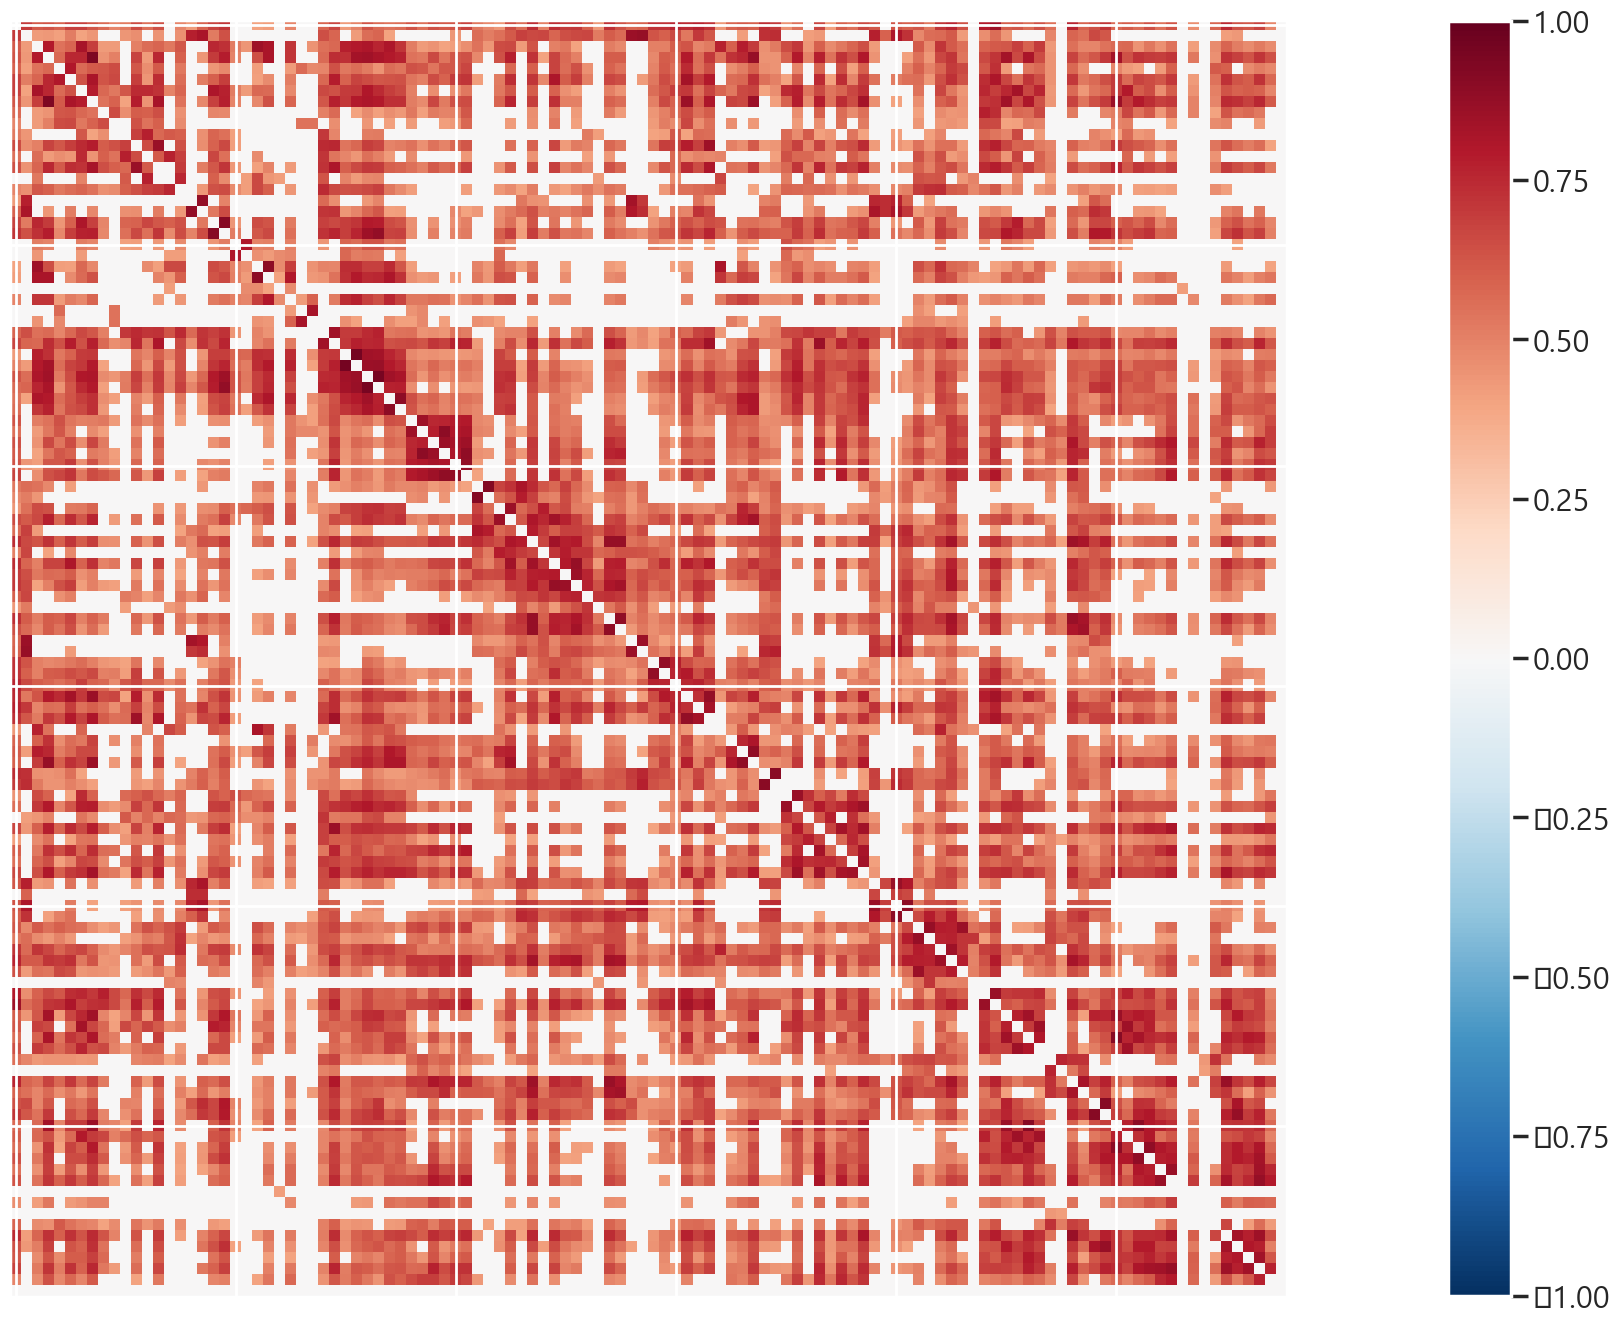

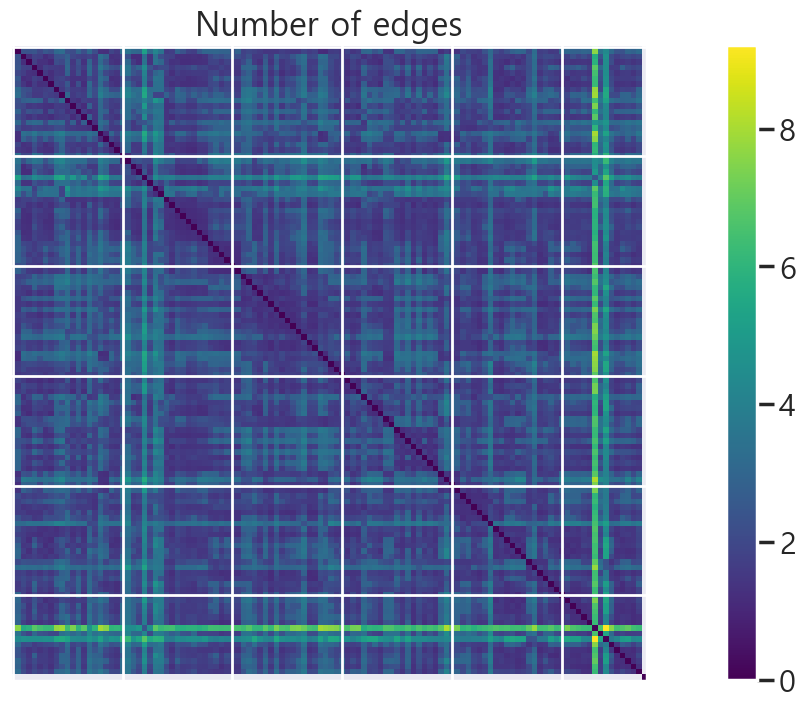

In [318]:
cmat = pd.read_csv("../resources/DataSujetos/W_suj1.csv",header=None) 

thresh_cmat = bct.threshold_absolute(cmat.values, thr=.4)

fig, ax = plt.subplots(figsize=(16, 16))
plotting.plot_matrix(thresh_cmat, vmax=1, vmin=-1, figure=fig);

A = thresh_cmat

A_inv = bct.weight_conversion(A, 'lengths')

dist, num = bct.distance_wei(A_inv)

fig, ax = plt.subplots(figsize=(8, 8))
plotting.plot_matrix(dist, vmin=0,
                     figure=fig, cmap='viridis')
ax.set_title('Number of edges');


degrees = bct.degrees_und(A)
strengths = bct.strengths_und(A)
eigin_cent = bct.eigenvector_centrality_und(A)
between_cent = bct.betweenness_wei(A_inv)

participation = bct.participation_coef(A, node_network)

atlas_img = nib.load(atlas['maps'])

res = stat_map(between_cent, atlas_img)
plotting.view_img(res, vmin=0, cmap='magma', symmetric_cmap=False)


C:\Users\Faolin\anaconda3\lib\site-packages\bct\algorithms\centrality.py:760: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)
C:\Users\Faolin\anaconda3\lib\site-packages\nilearn\plotting\js_plotting_utils.py:85: UserWarning: choosing both vmin and a threshold is not allowed; setting vmin to 0
  warnings.warn('choosing both vmin and a threshold is not allowed; '



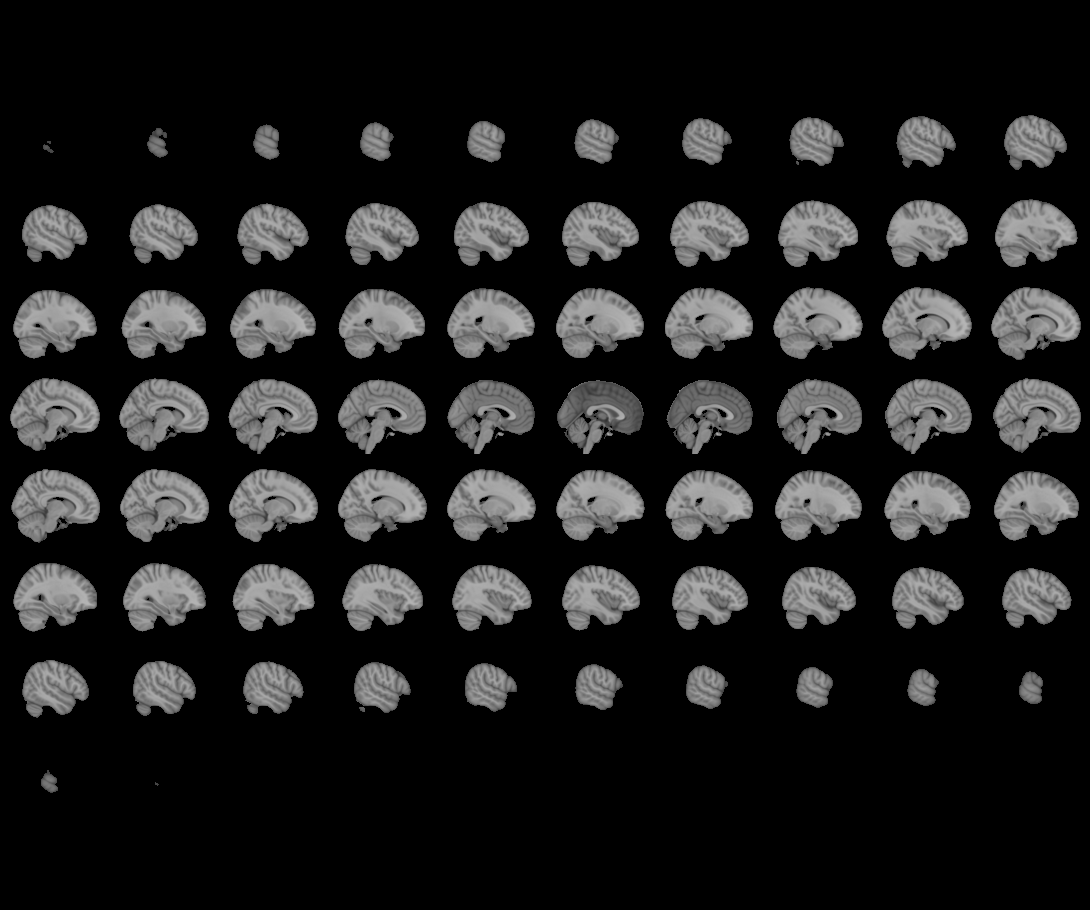
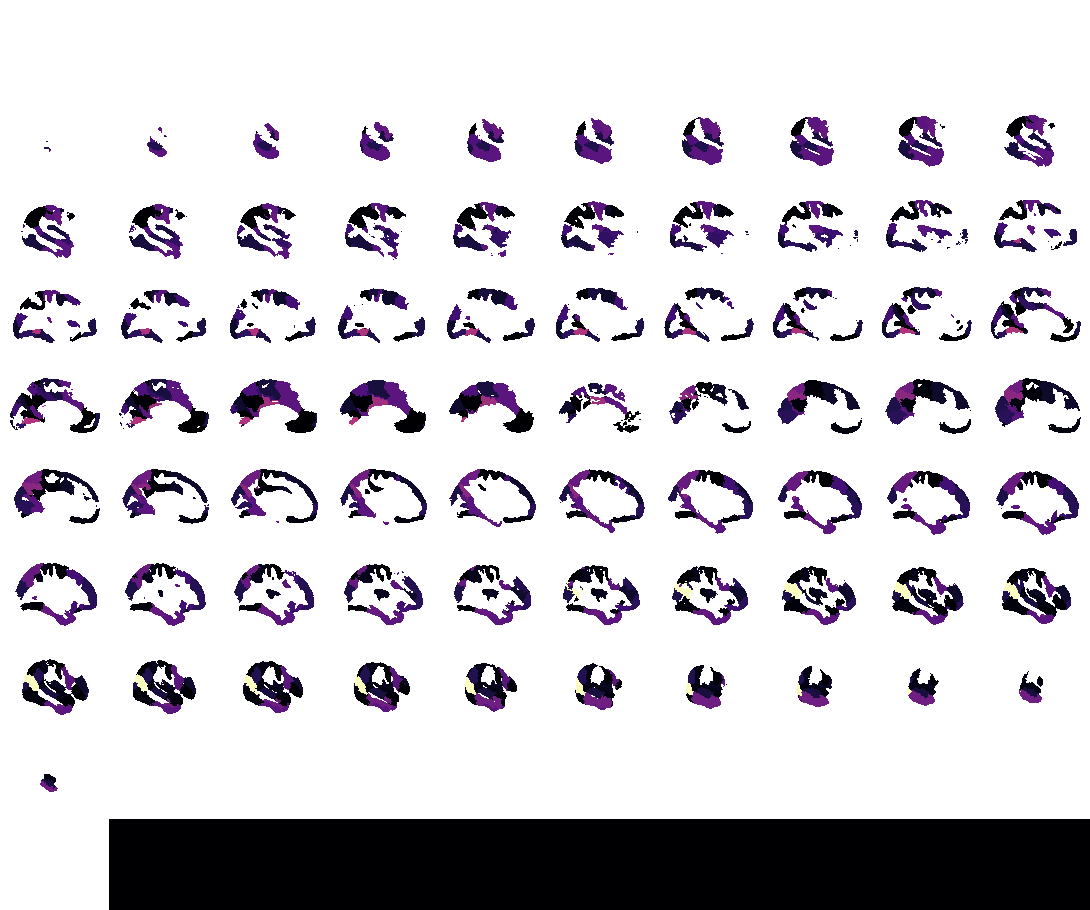

C:\Users\Faolin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Faolin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


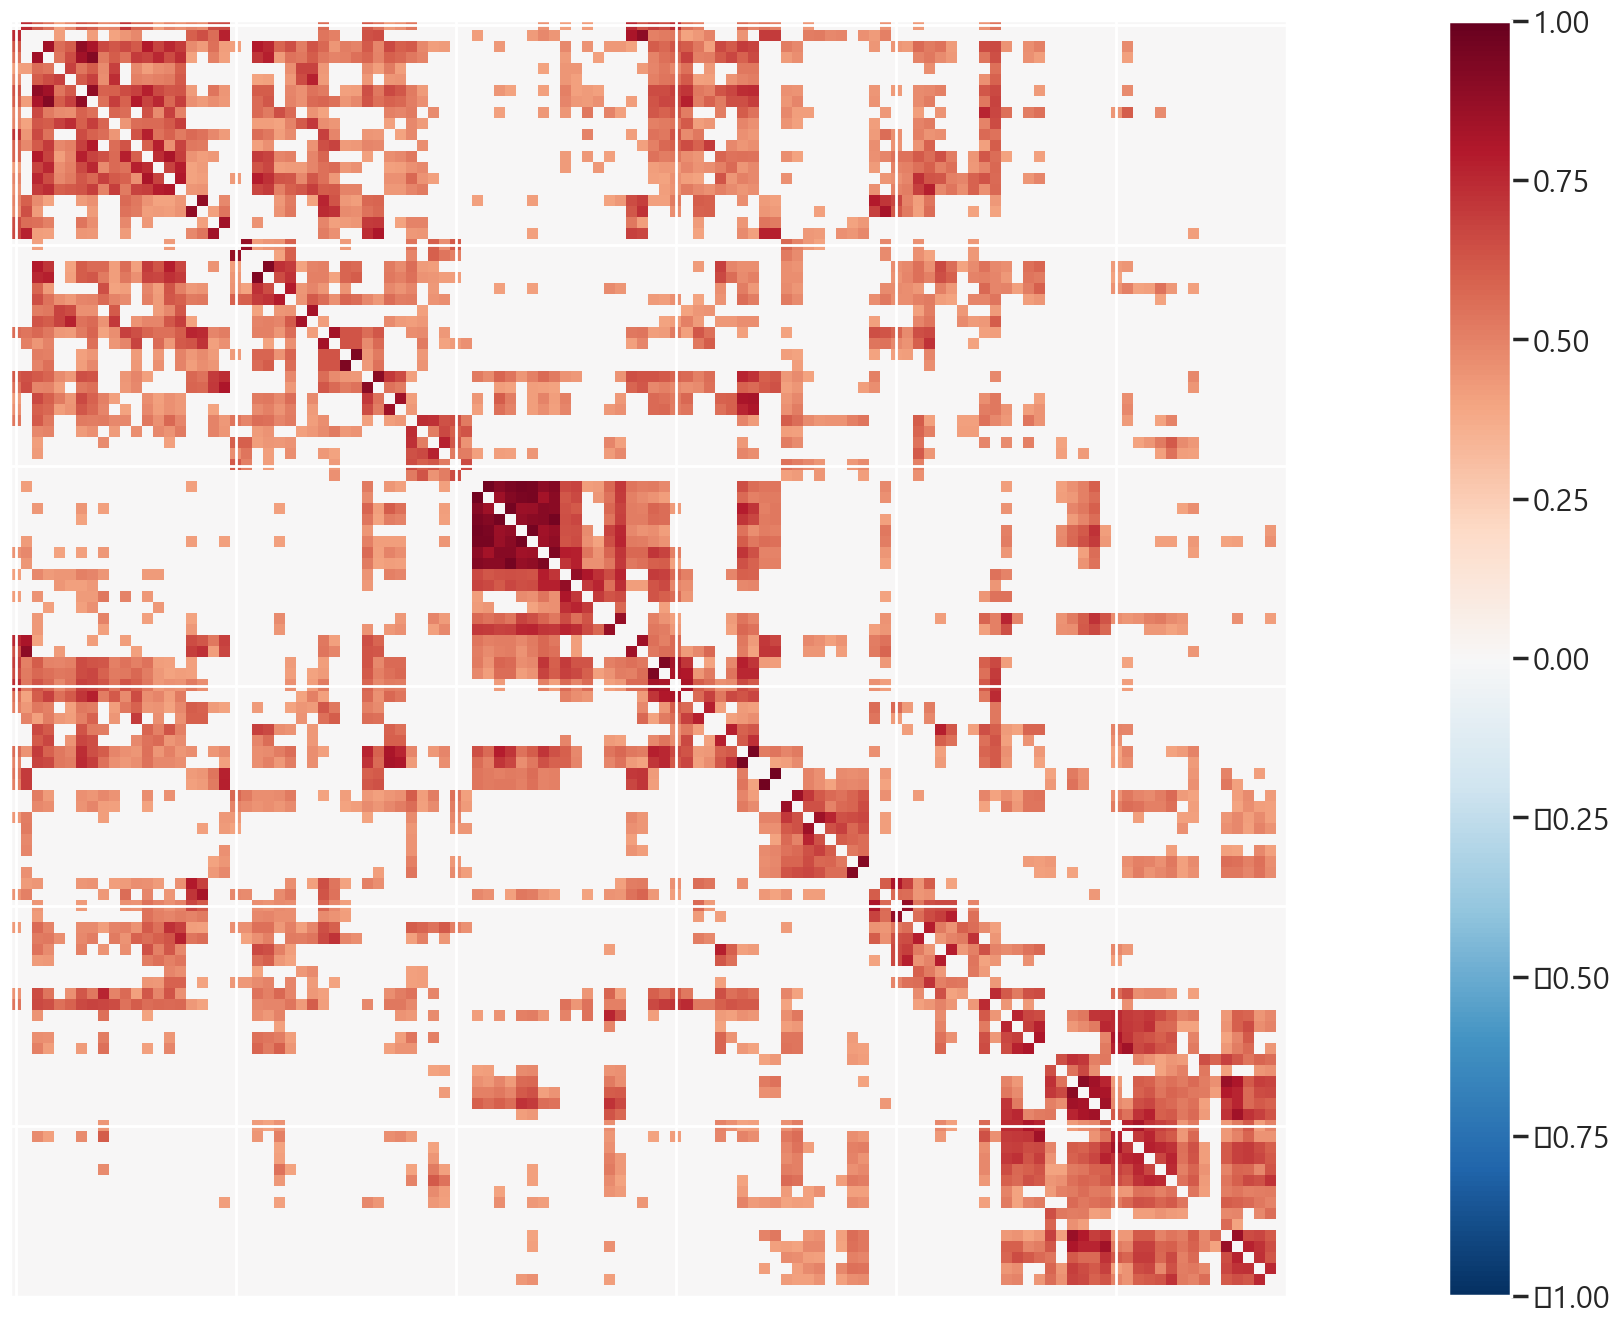

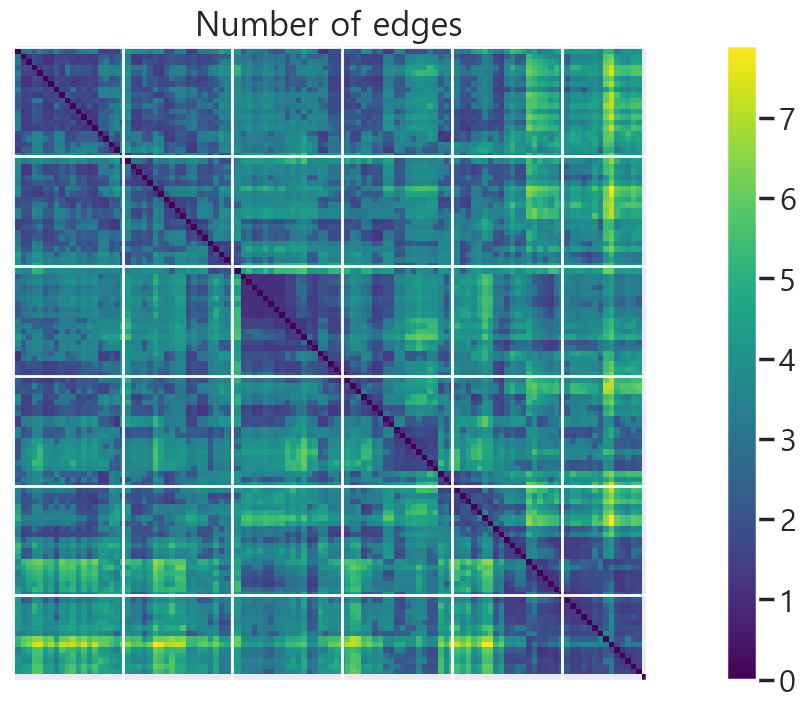

In [319]:
cmat = pd.read_csv("../resources/DataSujetos/N3_suj1.csv",header=None) 

thresh_cmat = bct.threshold_absolute(cmat.values, thr=.4)

fig, ax = plt.subplots(figsize=(16, 16))
plotting.plot_matrix(thresh_cmat, vmax=1, vmin=-1, figure=fig);

A = thresh_cmat

A_inv = bct.weight_conversion(A, 'lengths')

dist, num = bct.distance_wei(A_inv)

fig, ax = plt.subplots(figsize=(8, 8))
plotting.plot_matrix(dist, vmin=0,
                     figure=fig, cmap='viridis')
ax.set_title('Number of edges');


degrees = bct.degrees_und(A)
strengths = bct.strengths_und(A)
eigin_cent = bct.eigenvector_centrality_und(A)
between_cent = bct.betweenness_wei(A_inv)

participation = bct.participation_coef(A, node_network)

atlas_img = nib.load(atlas['maps'])

res = stat_map(between_cent, atlas_img)
plotting.view_img(res, vmin=0, cmap='magma', symmetric_cmap=False)
